In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Setting to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# sklearn
from sklearn.metrics import *

# Rajout des données
## Calul des ratios

### A faire :
- renommer les colonnes avec les codifications cerfa (sous forme de dictionnaire). Réfléchir à la façon dont les infos seront ensuite récupérées depuis l'UI (formulaire ? scan des données ? Prévoir de rajouter à chaque fois les infos dans la db ? => visiblement non, la DB utilisée seulement pour entrainer le modèle)
- distinguer les types de variables (bilan, cdr, autres infos...). => OK
- créer les variables "ratios" (les nommer R1, R2...)
- les mettre en DB (à quel moment ?)
- distinguer les variables qualitatives et quantitatives


- prendre tous les ratios + certains champs en valeur. Pour déterminer les champs en valeur à prendre, calculer les corrélations + faire graphes + Feature Importance.

- penser à travailler sur les résidus (rajouter des modèles les uns sur les autres)



- Prévoir dans la DB une table pour les ratios, une autre pour le bilan, une pour le CDR... Réfléchir au meilleur schéma. Prévoir une table avec les types d'entreprises. Prévoir une table indiquant les types de données : CDR, bilan... ? 


In [58]:
df = pd.read_csv("../data/data_used/total.csv")

In [59]:
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2016 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2016 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2016 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
             + df['Marchandises (net) (BTNET) 2016 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2016 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2016 (€)']
        + df['Disponibilités (net) (CFNET) 2016 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
        - df['Dettes fiscales et sociales (DY) 2016 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
        - df['Autres dettes (EA) 2016 (€)']
        - df["Produits constatés d'avance (EB) 2016 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)']
                 + df['En cours de production de services (net) (BPNET) 2016 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2016 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
                 + df['Marchandises (net) (BTNET) 2016 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2016 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                - df['Dettes fiscales et sociales (DY) 2016 (€)']
                - df['Autres dettes (EA) 2016 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2016 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2016 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2016 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2016 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2016 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2016 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2016 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2016 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2016 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2016 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2016 (€)"]
                - df['Impôts sur les bénéfices (HK) 2016 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2016 (€)']
                 + df['TOTAL(II) (DO) 2016 (€)']
                 + df['TOTAL (III) (DR) 2016 (€)']
                 + df['Autres emprunts obligataires (DT) 2016 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2016 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2016 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2016 (€)']
                 - df['Primes de remboursement des obligations (CM) 2016 (€)']
                 - df['Ecarts de conversion actif (CN) 2016 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2016 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"] 
                                    / (df['TOTAL (I) (DL) 2016 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2016 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]
                + df["Subventions d'exploitation (FO) 2016 (€)"]
                + df['Production stockée (FM) 2016 (€)']
                + df['Production immobilisée (FN) 2016 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2016 (€)']
                - df['Variation de stock (marchandises) (FT) 2016 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2016 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2016 (€)']
                - df['Salaires et traitements (FY) 2016 (€)']
                - df['Charges sociales (10) (FZ) 2016 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2016 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2016 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2016 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2016 (€)']
                + df['Salaires et traitements (FY) 2016 (€)']
                + df['Charges sociales (10) (FZ) 2016 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2016 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2016 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2016 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
                                 + df['Autres dettes (EA) 2016 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2016 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2016 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2016 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2016 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2016 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2016 (€)']
                                 + df['Marchandises (net) (BTNET) 2016 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2016 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2016 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)']
                                 + df['Autres dettes (EA) 2016 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2016 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"]
                                             / (df['TOTAL (I) (DL) 2016 (€)']
                                                + df['TOTAL(II) (DO) 2016 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2016 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2016 (€)']
                                                + df['TOTAL(II) (DO) 2016 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2016 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2016 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2016 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2016 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2016 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2016 (€)"])


    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2016 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2016 (€)'])

    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    return df

In [60]:
df = calcul_ratios(df)

## Merge avec données NAF

In [61]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [62]:
df, df_naf = merge_naf(df, naf_path="../data/data_used/table_nAF2-NA.xls")

## Date de création => rajout d'une colonne sur l'âge

In [63]:
import datetime
def ajout_col_age(df):
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    return df

In [64]:
df = ajout_col_age(df)

## Suppression des colonnes absolument inutiles
- Supprimer toutes les colonnes qui sont intégrées dans les ratios et qui ne servent qu'à cela :
- Supprimer toutes les colonnes qui 


### Définition des catégories de colonnes

In [65]:
target_col = ['default']

In [66]:
#naf_cols = df_naf.columns.to_list()
naf_cols = ['A 732',
 'Descriptif A 732',
 'A 615',
 'A 272',
 'A 129',
 'A 88',
 'A 64',
 'A 38',
 'A 21',
 'A 10']
naf_cols_to_drop = ['A 732',
 'Descriptif A 732',
 'A 615',
 'A 272',
 'A 129',
 'A 88',
 'A 64',
 'A 38']
naf_cols_to_keep = [col for col in naf_cols if col not in naf_cols_to_drop]
naf_cols_to_keep

['A 21', 'A 10']

In [67]:
general_cols = ['SIREN', 
           'Dénomination', 
           'SIRET', 
           'Code APE', 
           'Procédures collectives (type)', 
           'Procédures collectives (date)', 
           'Code postal', 
           'Date de création', 
            'Age entreprise', 
           'Tranche effectifs', 
           'Catégorie juridique (Niveau I)', 
           'Ville', 
           "Nombre de mois de l'exercice comptable 2016", 
           'Notation NOTA-PME 2016', 
           'Catégorie juridique (Niveau II)',
            'Effectif moyen du personnel (YP) 2016']

general_cols_to_drop = ['SIREN', 
           'Dénomination', 
           'SIRET', 
           'Code APE', # présent dans les colonnes NAF (A 732)            
           'Procédures collectives (type)', 
           'Procédures collectives (date)', 
           'Code postal', # à reprendre après pour analyse géographique
           'Date de création', 
           'Ville',
                        
           'Notation NOTA-PME 2016', 
            'Catégorie juridique (Niveau I)',
           'Catégorie juridique (Niveau II)',
            'Effectif moyen du personnel (YP) 2016']

general_cols_to_keep = [col for col in general_cols if col not in general_cols_to_drop]
general_cols_to_keep

['Age entreprise',
 'Tranche effectifs',
 "Nombre de mois de l'exercice comptable 2016"]

In [68]:
important_cols = ['TOTAL (I) (DL) 2016 (€)',
                    "Chiffre d'affaires net (Total) (FL) 2016 (€)",
                    '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)',
                    'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)']

In [70]:
bilan_cols = ['Capital souscrit non appelé (I) (AA) 2016 (€)', 
         'TOTAL (II) (net) (BJNET) 2016 (€)', 
         'Matières premières, approvisionnements (net) (BLNET) 2016 (€)', 
         'En cours de production de biens (net) (BNNET) 2016 (€)', 
         'En cours de production de services (net) (BPNET) 2016 (€)', 
         'Produits intermédiaires et finis (net) (BRNET) 2016 (€)', 
         'Marchandises (net) (BTNET) 2016 (€)', 
         'Avances et acomptes versés sur commandes (net) (BVNET) 2016 (€)', 
         'Clients et comptes rattachés (3) (net) (BXNET) 2016 (€)', 
         'Autres créances (3) (net) (BZNET) 2016 (€)', 
         'Capital souscrit et appelé, non versé (net) (CBNET) 2016 (€)', 
         'Valeurs mobilières de placement (net) (CDNET) 2016 (€)', 
         'Disponibilités (net) (CFNET) 2016 (€)', 
         "Charges constatées d'avance (3) (net) (CHNET) 2016 (€)", 
         'TOTAL (III) (net) (CJNET) 2016 (€)', 
         'Primes de remboursement des obligations (CM) 2016 (€)', 
         'Ecarts de conversion actif (CN) 2016 (€)', 
         'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)', 
         'Capital social ou individuel (1) (DA) 2016 (€)', 
         'Report à nouveau (DH) 2016 (€)', 
         "RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2016 (€)", 
         'TOTAL (I) (DL) 2016 (€)', 
         'TOTAL(II) (DO) 2016 (€)', 
         'TOTAL (III) (DR) 2016 (€)', 
         'Autres emprunts obligataires (DT) 2016 (€)', 
         'Emprunts obligataires convertibles (DS) 2016 (€)', 
         'Emprunts et dettes auprès des établissements de crédit (5) (DU) 2016 (€)', 
         'Emprunts et dettes financières divers (DV) 2016 (€)', 
         'Avances et acomptes reçus sur commandes en cours (DW) 2016 (€)', 
         'Dettes fournisseurs et comptes rattachés (DX) 2016 (€)', 
         'Dettes fiscales et sociales (DY) 2016 (€)', 
         'Dettes sur immobilisations et comptes rattachés (DZ) 2016 (€)', 
         'Autres dettes (EA) 2016 (€)', 
         "dont comptes courants d'associés de l'exercice N (EA2) 2016 (€)", 
         "Produits constatés d'avance (EB) 2016 (€)", 
         'TOTAL (IV) (EC) 2016 (€)', 
         'TOTAL GENERAL (I à V) (EE) 2016 (€)', 
         '(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2016 (€)',
         'Ecarts de conversion passif (V) (ED) 2016 (€)']

In [71]:
cdr_cols = ["Chiffre d'affaires net (France) (FJ) 2016 (€)", 
       "Chiffre d'affaires net (Exportations et livraisons intracommunautaires) (FK) 2016 (€)", 
       "Chiffre d'affaires net (Total) (FL) 2016 (€)", 
       "Subventions d'exploitation (FO) 2016 (€)", 
       'Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2016 (€)', 
       "Total des produits d'exploitation (2) (I) (FR) 2016 (€)", 
       'Achats de marchandises (y compris droits de douane) (FS) 2016 (€)', 
       'Variation de stock (marchandises) (FT) 2016 (€)', 
       'Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2016 (€)', 
       'Variation de stock (matières premières et approvisionnements) (FV) 2016 (€)', 
       'Autres achats et charges externes (3) (6 bis) (FW) 2016 (€)', 
       'Impôts, taxes et versements assimilés (FX) 2016 (€)', 
       'Salaires et traitements (FY) 2016 (€)', 
       'Charges sociales (10) (FZ) 2016 (€)', 
       "Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2016 (€)", 
       "Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2016 (€)", 
       "Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2016 (€)", 
       "Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2016 (€)", 
       'Autres charges (12) (GE) 2016 (€)', 
       "Total des charges d'exploitation (4) (II) (GF) 2016 (€)", 
       "1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2016 (€)", 
       'Total des produits financiers (V) (GP) 2016 (€)', 
       'Intérêts et charges assimilées (GR) 2016 (€)', 
       'Total des charges financières (VI) (GU) 2016 (€)', 
       'Dotations financières aux amortissements et provisions (GQ) 2016 (€)', 
       'Reprises sur provisions & transferts de charges (GM) 2016 (€)', 
       'Total des produits exceptionnels (VII) (HD) 2016 (€)', 
       'Reprises sur provisions & transferts de charges (HC) 2016 (€)', 
       'Dotations exceptionnelles aux amortissements et provisions (6 ter) (HG) 2016 (€)', 
       'Total des charges exceptionnelles (VIII) (HH) 2016 (€)', 
       '4 - RESULTAT EXCEPTIONNEL (VII - VIII) (HI) 2016 (€)', 
       '5 - BENEFICE OU PERTE (Total des produits - total des charges) (HN) 2016 (€)', 
       "Participation des salariés aux résultats de l'entreprise (HJ) 2016 (€)", 
       'Impôts sur les bénéfices (HK) 2016 (€)',
       'Production stockée (FM) 2016 (€)', 
       'Production immobilisée (FN) 2016 (€)',
       '(3)\xa0Dont Crédit-bail mobilier (HP) 2016 (€)', 
       '(3)\xa0Dont Crédit-bail immobilier (HQ) 2016 (€)', 
       '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)']

In [72]:
annexes_cols = ['Clients douteux ou litigieux - Montant brut (VA) 2016 (€)', 
           'Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2016 (€)', 
           'Impôts sur les bénéfices - Montant brut (8E) 2016 (€)', 
           'T.V.A. - Montant brut (VW) 2016 (€)', 
           'Emprunts remboursés en cours d’exercice (VK) 2016 (€)', 
           'Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2016 (€)', 
           "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2016 (€)", 
           'Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2016 (€)', 
           'Effets portés à l’escompte et non échus (YS) 2016 (€)', 
           'Sous‐traitance (YT) 2016 (€)']

In [73]:
ratios_cols = ['Credit client',
 'Credit Fournisseurs',
 'Rotation_stocks',
 'BFR',
 'BFRE',
 'Endettement total',
 'CAF',
 'Capacite de remboursement',
 'Ressources durables',
 'FRNG',
 'Taux endettement',
 'Rentabilite financiere',
 'EBE',
 'VA',
 'Liquidite generale',
 'Liquidite reduite',
 'Taux ressources propres',
 'Rentabilite des capitaux propres',
 'Autonomie financiere',
 'Poids interets',
 'Taux EBE',
 'Taux VA',
 'Taux Rentabilite',
 'Poids dettes fiscales',
 'Taux augmentation endettement CT',
 'Tresorerie']

In [76]:
cols_to_keep = (ratios_cols 
                + target_col 
                + general_cols_to_keep 
                + important_cols
                + naf_cols_to_keep)
print(len(cols_to_keep))

36


# Analyse de la forme du dataset dans sa totalité

In [77]:
df.shape

(9750, 141)

### Analyse des types de variables


In [78]:
# identifier le nombre de variables catégorielles et numériques
df.dtypes.value_counts()

int64             103
float64            21
object             16
datetime64[ns]      1
dtype: int64

<AxesSubplot:ylabel='None'>

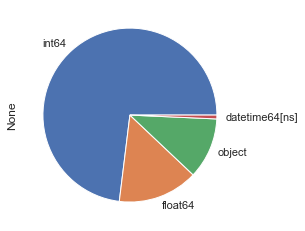

In [79]:
df.dtypes.value_counts().plot.pie()

### Variables catégorielles
- Seulement 10 variables sont catégorielles. Parmi elles :
    - Variables à supprimer (nombre de modalités trop important ou pas assez, ne permettant pas d'apporter ) : ["Dénomination", "Procédures collectives (type)", "Procédures collectives (date)", "Ville", "Notation NOTA-PME 2016"]
    - Tranches d'effectifs : 14. A conserver. Peut-être à imputer ? Faire le lien avec le nombre de salariés
    - Code APE : 534 valeurs uniques c'est trop. Prendre une table de correspondance INSEE pour réduire le champ (NA 38 ?)
    - Ville : pour l'instant à supprimer. Voir ultérieurement si ça peut être pertinent de travailler dessus (nombre d'habitants dans la ville ou bien rayon autour...)
    - Date de création : passer en format date. Peut-être le remplacer par le nombre d'années d'ancienneté
    - Catégorie juridique : soit supprimer les données, soit imputer les valeurs manquantes de la categ de niveau II
    - A noter pour plus tard :
        - Mettre en lien la ville avec le nombre d'habitants, la présence ou non d'une aire urbaine...
        - Préciser la catégorie juridique de niveau II

In [80]:
# identifier le nombre de modalités pour les variables catégorielles
for col in df.select_dtypes('object').columns:
    print(col, len(df[col].value_counts()))

Dénomination 9651
Code APE 534
Procédures collectives (type) 820
Procédures collectives (date) 3386
Tranche effectifs 14
Catégorie juridique (Niveau I) 4
Ville 3805
Notation NOTA-PME 2016 102
Catégorie juridique (Niveau II) 13
A 732 534
Descriptif A 732 534
A 129 110
A 64 57
A 38 33
A 21 18
A 10 10


In [81]:
# identifier les modalités prises par les variables catégorielles affichant moins de 20 modalités
categ = ["Tranche effectifs", "Catégorie juridique (Niveau I)", "Catégorie juridique (Niveau II)"]
for col in categ:
    print(f'{col :-<30} {df[col].unique()}')

Tranche effectifs------------- ['De 1000 à 1999 salariés' 'De 3 à 5 salariés' 'De 500 à 999 salariés'
 'De 100 à 199 salariés' 'De 200 à 249 salariés' 'De 250 à 499 salariés'
 'De 50 à 99 salariés' 'De 10 à 19 salariés' 'De 1 à 2 salariés'
 'De 20 à 49 salariés' "0 salarié pendant l'année"
 "0 salarié à la fin de l'année" nan 'De 6 à 9 salariés'
 'De 2000 à 4999 salariés']
Catégorie juridique (Niveau I) ['Société commerciale' 'Entrepreneur individuel'
 'Autre personne morale immatriculée au RCS'
 'Personne morale de droit étranger' nan]
Catégorie juridique (Niveau II) [nan "Société anonyme à conseil d'administration"
 'Société par actions simplifiée' 'Société anonyme à directoire'
 'Société à responsabilité limitée (SARL)' 'Société en nom collectif'
 'Entrepreneur individuel' 'Société civile' 'Société en commandite'
 "Groupement d'intérêt économique" 'Société coopérative agricole'
 'Personne morale de droit étranger, immatriculée au RCS (registre du commerce et des sociétés)'
 'Société

**Tranche d'effectifs**
- variable ordinale, recherche des différentes modalités.
- choix d'utiliser Tranche d'effectif plutôt qu'effectif moyen du personnel
- pour l'imputation des valeurs manquantes (il y en a 1240 soit 12,7%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.

In [82]:
# Choix entre effectif moyen du personnel et tranche d'effectifs => choix de tranche d'effectifs qui est davantage renseignée ()
df[['Effectif moyen du personnel (YP) 2016', "Tranche effectifs"]].describe(include='all')

Effectif moyen du personnel (YP) 2016  Tranche effectifs
count                              9750.00000               8510
unique                                    NaN                 14
top                                       NaN  De 1 à 2 salariés
freq                                      NaN               1607
mean                                  4.98913                NaN
std                                  55.70324                NaN
min                                   0.00000                NaN
25%                                   0.00000                NaN
50%                                   0.00000                NaN
75%                                   0.00000                NaN
max                                4417.00000                NaN

In [83]:
# variable ordinale, recherche des différentes modalités.
# pour l'imputation des valeurs manquantes (il y en a 1240 soit 12,7%) => plusieurs options. Soit le plus fréquent (ici tranche 2), soit info en tant que telle (mettre un -999 par ex), soit supprimer la colonne ou les lignes, soit imputer en utilisant les KNN.
df["Tranche effectifs"].value_counts()

De 1 à 2 salariés                1607
De 3 à 5 salariés                1386
De 10 à 19 salariés              1277
De 6 à 9 salariés                1197
De 20 à 49 salariés               937
0 salarié à la fin de l'année     903
0 salarié pendant l'année         766
De 50 à 99 salariés               243
De 100 à 199 salariés             117
De 250 à 499 salariés              31
De 200 à 249 salariés              28
De 500 à 999 salariés              12
De 1000 à 1999 salariés             4
De 2000 à 4999 salariés             2
Name: Tranche effectifs, dtype: int64

In [84]:
dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
}

### Valeurs manquantes

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

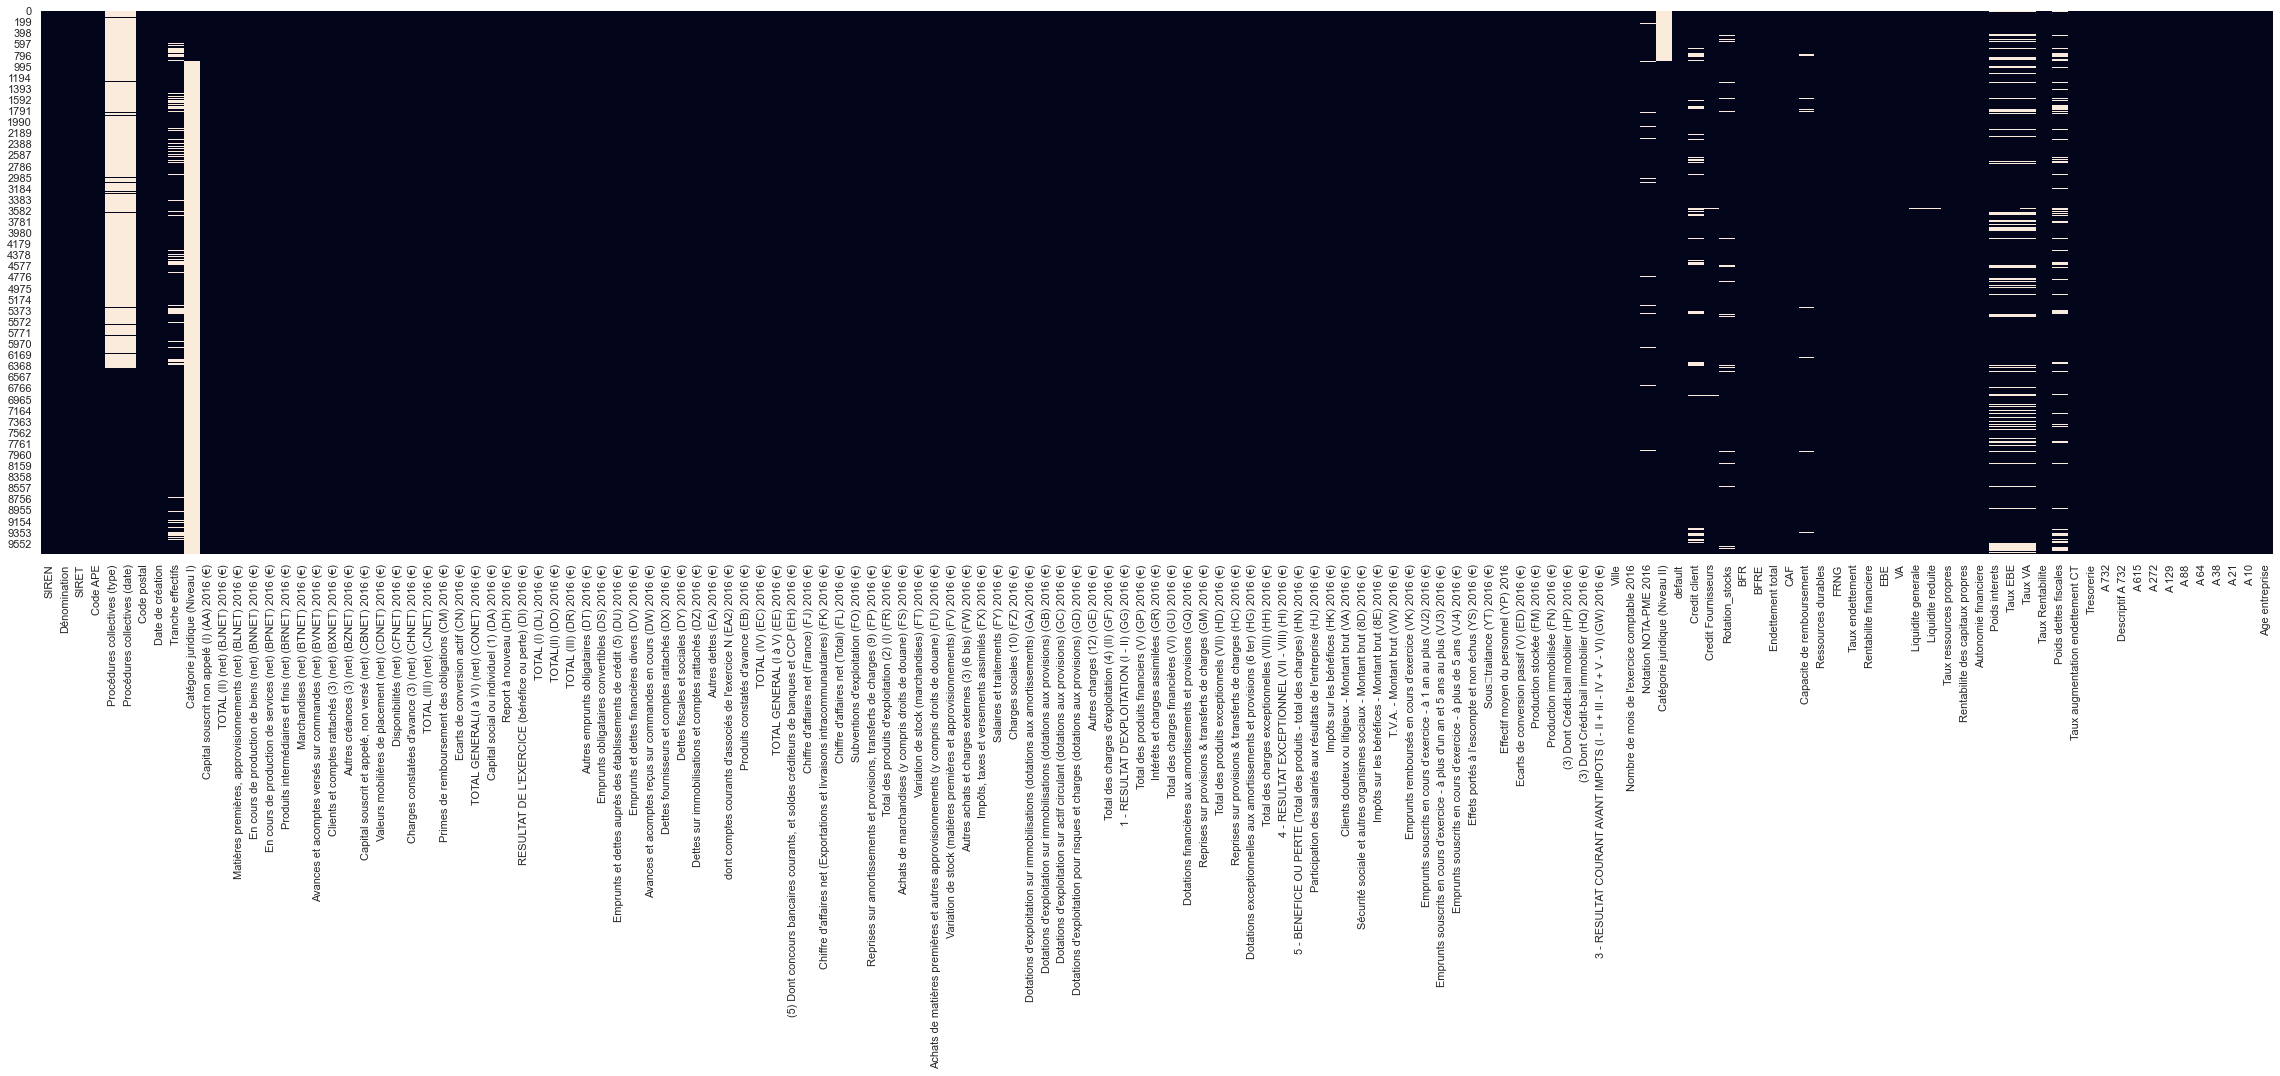

In [85]:
# heatmap des valeurs manquantes (en blanc)
plt.figure(figsize=(40,10))
sns.heatmap(df.isna(), cbar=False)

In [86]:
# total de NaN sur le dataset
df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100

2.2804873613384253

In [87]:
# taux de NaN par colonne
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Catégorie juridique (Niveau I)                                                                         0.90708
Procédures collectives (type)                                                                          0.63621
Procédures collectives (date)                                                                          0.63621
Poids interets                                                                                         0.16185
Taux VA                                                                                                0.16062
Taux EBE                                                                                               0.16000
Poids dettes fiscales                                                                                  0.13908
Tranche effectifs                                                                                      0.12718
Catégorie juridique (Niveau II)                                                                        0.09292
C

#### Focus sur les entreprises avec un CA null
- 2302 entreprises avec CA null (1541 saines et 761 défaillantes)
- Conséquence sur les ratios => 
- Est-ce pertinent de garder ces entreprises ? Comment reformuler cette question ? 
    - Est ce que la distribution (entre des entreprises ayant un CA nul et celle n'en ayant pas est significativement différente ?

In [88]:
CA_null = df[df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]==0]

In [89]:
CA_not_null = df[df["Chiffre d'affaires net (Total) (FL) 2016 (€)"]!=0]

<AxesSubplot:xlabel="Chiffre d'affaires net (Total) (FL) 2016 (€)", ylabel='default'>

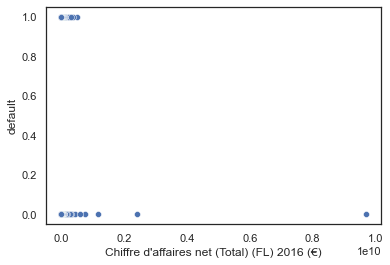

In [90]:
sns.scatterplot(x="Chiffre d'affaires net (Total) (FL) 2016 (€)", y= "default", data = df)

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

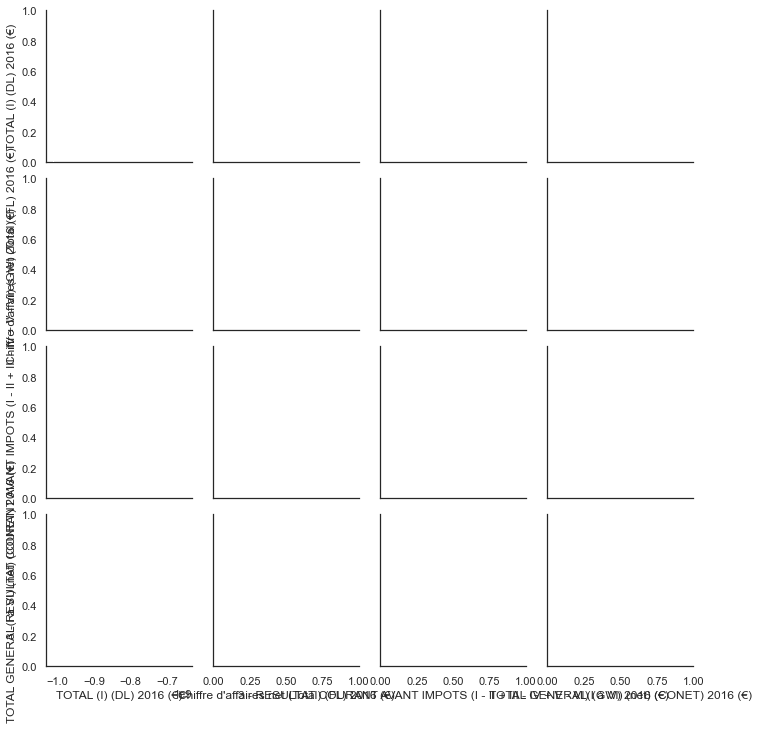

In [91]:
plt.figure(figsize=(10,10))
g = sns.pairplot(df[important_cols])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_yticklabels(g.get_yticklabels(), rotation=90)

In [92]:
CA_null[target_col].value_counts()

default
0.00000    1541
1.00000     761
dtype: int64

# Baseline 0 : uniquement ratios cols, suppression des NaN
- Uniquement les ratio_cols
- Step 2 --> Gestion des NaN 
    - Suppression des lignes avec des valeurs nulles ou infinies (de 9750 à 7273 lignes) On vérifie que la part des saines/default est stable et c'est le cas : le taux d'entreprises en défault passe de 34.256% à 34.745%, on peut dire qu'il reste stable.
    - On a au final une df de 7273 lignes et 27 colonnes.

- AVANT Imputation
    - (9750, 27)
    - 0.00000   0.65744
    - 1.00000   0.34256


- APRES Imputation
    - (7273, 27)
    - 0.00000   0.65255
    - 1.00000   0.34745

- Step 3 --> Gestion des variables catégorielles
    - On n'a que des variables numériques (aucune variable catégorielle sur les ratios) => pas d'encodage à faire
    
- Step 4 --> Train test split

- Step 5 --> Modèle de régression logistique (attention c'est à ce niveau qu'est opéré le préprocessing de normalisation !!!)
    - Résultats :
- CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
            0          944           18    962
            1          447           46    493
                       1391           64   1455

- CLASSIFICATION REPORT 
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       962
         1.0       0.72      0.09      0.17       493

    
    
    - Interprétation des résultats :
    
- Sur les 493 positifs, seulement 46 ont été identifiés comme tels soit un recall de 0,09 ce qui est un très mauvais score. C'est pourtant essentiellement cette métrique que l'on cherche à améliorer
- Sur les 64 prédits positifs, 46 le sont réellement soit une précision de 0,72. On parvient ainsi à une accuracy de 0,66 et un F1 score de 0,17
- On cherche à accroitre le recall, en diminuant le nombre / la proportion de faux négatifs
=> Il semble que :
    - Soit le modèle n'est pas du tout adapté (modèle logistique - quelles sont les hypothèses derrière ?)
    - Soit le choix de features doit être revu (multicolinéarité ?)
    - Soit le préprocessing sur les features doit être revu (regarder les distributions des features, voir s'il est pertinent de normaliser avec la méthode employée, voir s'il est intéressant 
    - Soit (à la marge) les hyperparamètres du modèle doivent être revus 
        - notamment le threshold - voir https://kobia.fr/classification-metrics-precision-recall/ 
        - et le notebook sur les métriques de classification et les itérations, car on a un problème sur ce dernier plan : Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    - Soit tout ça en même temps


**Suites à donner :**
1) tester rapidement 2-3 autres modèles différents (SVM et random forest par exemple) pour voir si le type de modèle a un impact

2) aller plus en profondeur sur les données

#### Suppression des NaN

In [114]:
baseline = df.copy()
# sélection des colonnes à garder :
baseline = df[ratios_cols + target_col]

In [115]:
#baseline_0 : enlève toutes les lignes avec des NaN ou des infinis en plus
def imputation_v0(df):
    # Baseline 0 - suppression des lignes avec des NaN
    df = df.replace([np.inf, -np.inf], np.nan) # remplacement des infinis par des nan pour les supprimer aussi
    df = df.dropna(axis=0)
    return df

In [116]:
print("__---__ AVANT Imputation __---__")
print(baseline.shape)
print(baseline['default'].value_counts()/baseline.shape[0])
baseline = imputation_v0(baseline)
print("\n__---__ APRES Imputation __---__")
print(baseline.shape)
print(baseline['default'].value_counts()/baseline.shape[0])

__---__ AVANT Imputation __---__
(9750, 27)
0.00000   0.65744
1.00000   0.34256
Name: default, dtype: float64

__---__ APRES Imputation __---__
(7273, 27)
0.00000   0.65255
1.00000   0.34745
Name: default, dtype: float64


In [118]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 9739
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Credit client                     7273 non-null   float64
 1   Credit Fournisseurs               7273 non-null   float64
 2   Rotation_stocks                   7273 non-null   float64
 3   BFR                               7273 non-null   int64  
 4   BFRE                              7273 non-null   int64  
 5   Endettement total                 7273 non-null   int64  
 6   CAF                               7273 non-null   int64  
 7   Capacite de remboursement         7273 non-null   float64
 8   Ressources durables               7273 non-null   int64  
 9   FRNG                              7273 non-null   int64  
 10  Taux endettement                  7273 non-null   float64
 11  Rentabilite financiere            7273 non-null   float64
 12  EBE   

#### Train test split

In [119]:
from sklearn.model_selection import train_test_split

In [120]:
# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(baseline, test_size=0.2, random_state=0)

In [121]:
# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

0.00000   0.65040
1.00000   0.34960
Name: default, dtype: float64

In [122]:
testset['default'].value_counts(normalize=True)

0.00000   0.66117
1.00000   0.33883
Name: default, dtype: float64

#### Modèle + Normalisation
- Modèle 1 : normalisation + feature selection a priori (ratios + important features) ++ 
- Modèle 2 : normalisation + elastic net, garder initialement tous les features

In [123]:
X_train = trainset.drop(["default"], axis=1)
y_train = trainset["default"]
X_test = testset.drop(["default"], axis=1)
y_test = testset["default"]

In [128]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


model_1 = make_pipeline(StandardScaler(), LogisticRegression())

In [125]:
# model_1.fit(X_train, y_train)

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [135]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          944           18    962
Actual 1          447           46    493
TOTAL            1391           64   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       962
         1.0       0.72      0.09      0.17       493

    accuracy                           0.68      1455
   macro avg       0.70      0.54      0.48      1455
weighted avg       0.69      0.68      0.59      1455



/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

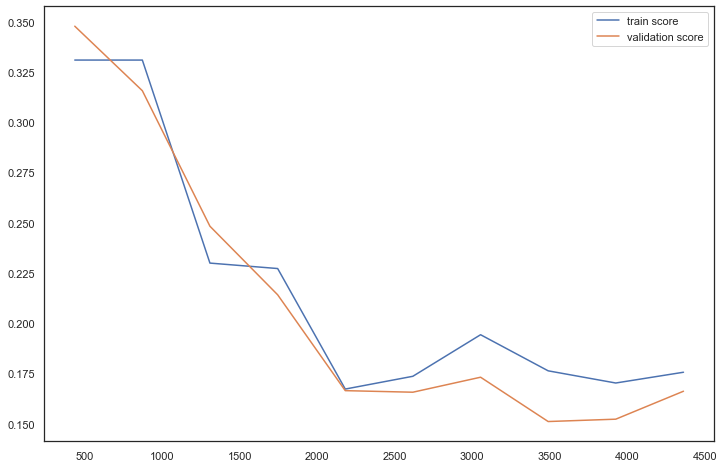

In [136]:
evaluation(model_1)

**CONCLUSIONS - Points à retravailler :**
- Mieux gérer le workflow (voir avec ML Flow pour enregistrer les métadonnées des modèles en parallèle si possible)
- Garder par exemple un tableau avec date/noms des features/prépro (et paramètres)/modèle (et hyperparamètres) / résultat / commentaires
- Premier test avec régression logistique (ne pas oublier qu'on est en classification !!) => 0.66 ce qui n'est pas si bon que ça compte tenu de la répartition des 0 et des 1. Travailler sur la balance des classes pour voir s'il est possible d'améliorer les choses (SMOTE ?)
- Tester avec moins de features / random forest ?

# V_1 : test d'autres modèles avec les mêmes datas et le même prépro que la baseline 0

- modele 2 : random forest (pas besoin de scaler les données)
- modèle 3 : svm

Je garde les X, y et train/test de la baseline 0
Je définis simplement 2 autres modèles

Conclusions - dans le cas d'un decision tree, on s'améliore sensiblement sur le recall au détriment de la précision :

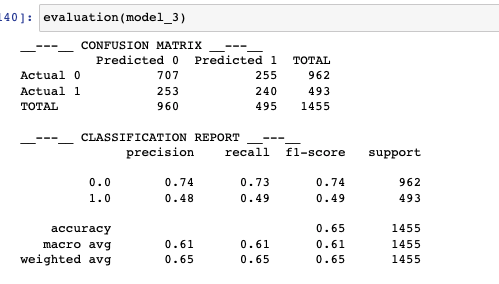

Dans le cas d'un random forest : attention il semble y avoir de l'overfitting

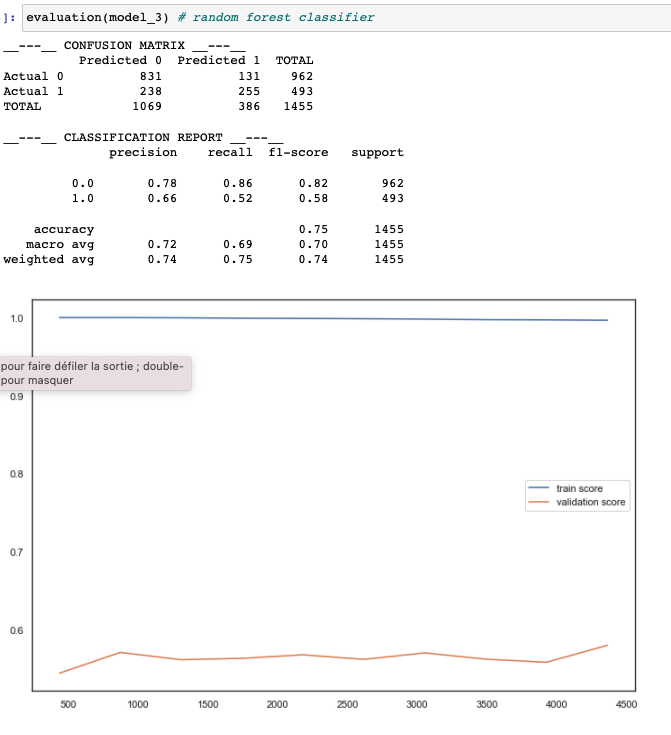

Dans le cas d'un SVM, on a à peu près les mêmes scores que pour la régression logistique :

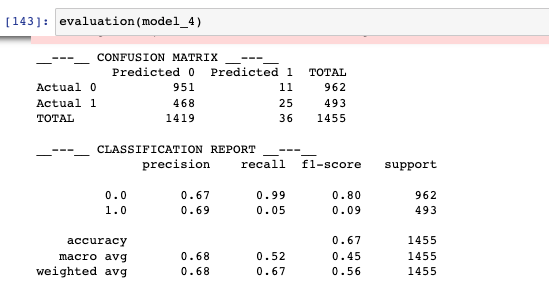

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          699          263    962
Actual 1          254          239    493
TOTAL             953          502   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       962
         1.0       0.48      0.48      0.48       493

    accuracy                           0.64      1455
   macro avg       0.60      0.61      0.61      1455
weighted avg       0.65      0.64      0.65      1455



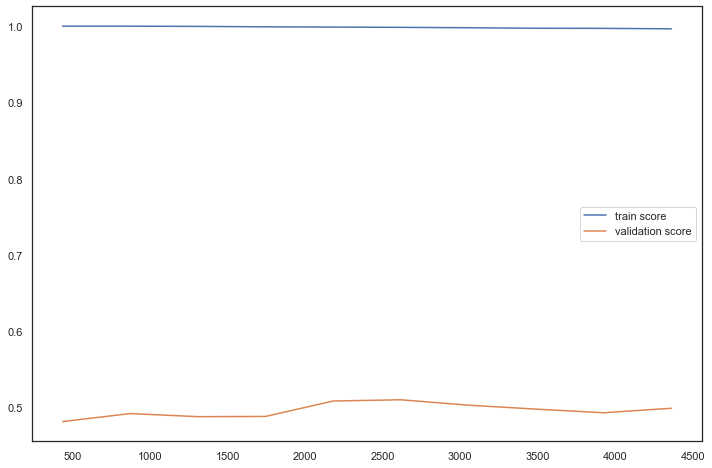

In [147]:
evaluation(model_2)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          707          255    962
Actual 1          253          240    493
TOTAL             960          495   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.74       962
         1.0       0.48      0.49      0.49       493

    accuracy                           0.65      1455
   macro avg       0.61      0.61      0.61      1455
weighted avg       0.65      0.65      0.65      1455



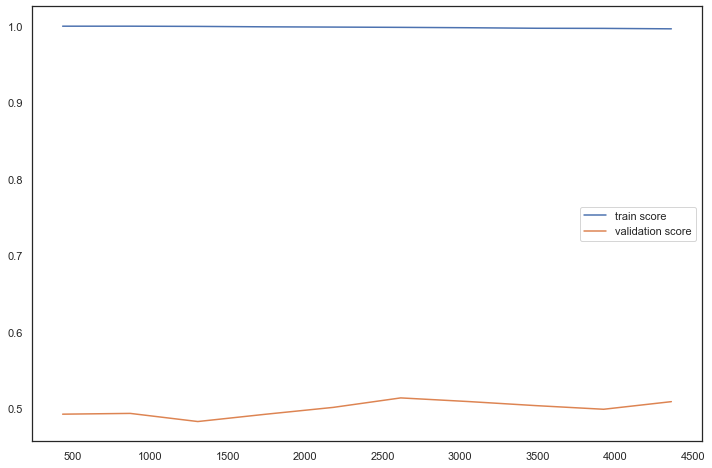

In [140]:
evaluation(model_4)

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          951           11    962
Actual 1          468           25    493
TOTAL            1419           36   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80       962
         1.0       0.69      0.05      0.09       493

    accuracy                           0.67      1455
   macro avg       0.68      0.52      0.45      1455
weighted avg       0.68      0.67      0.56      1455



/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


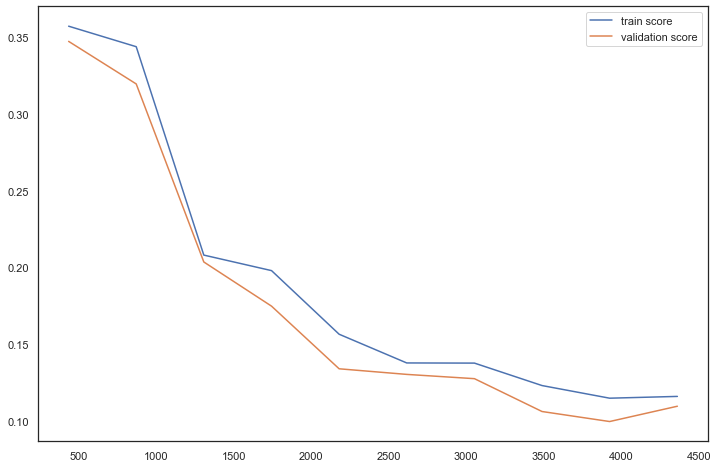

In [143]:
evaluation(model_4)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          831          131    962
Actual 1          238          255    493
TOTAL            1069          386   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       962
         1.0       0.66      0.52      0.58       493

    accuracy                           0.75      1455
   macro avg       0.72      0.69      0.70      1455
weighted avg       0.74      0.75      0.74      1455



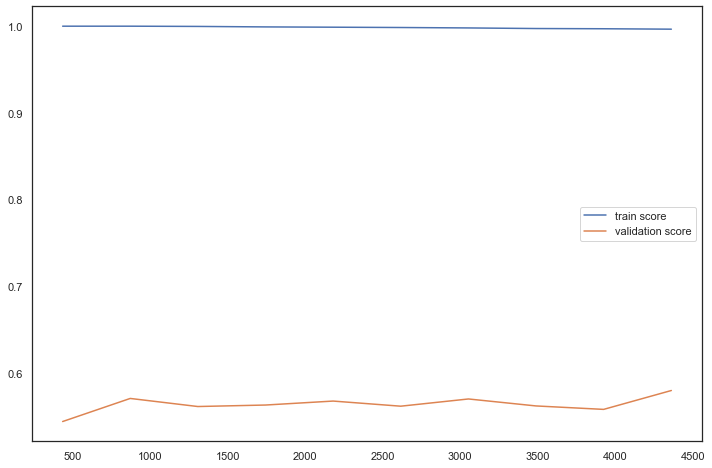

In [146]:
evaluation(model_3) # random forest classifier

# Autre tentative : garder tous les features et laisser la machine se débrouiller

In [ ]:
# mettre en paramètre de la fonction d'évaluation les datas pour le faire varier aussi

In [159]:
df2 = df.copy()

In [160]:
df2 = df2.select_dtypes(exclude=['object', 'datetime'])

In [161]:
df2 = imputation_v0(df2)
X = df2.drop(["default"], axis=1)
y = df2["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [285]:
eda_log.shape

(0, 33)

In [284]:
eda_log = imputation_v0(eda_log)
X = eda_log.drop(["default"], axis=1)
y = eda_log["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [222]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

model_1 = make_pipeline(StandardScaler(),LogisticRegression())
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
model_5 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          897           50    947
Actual 1          399          109    508
TOTAL            1296          159   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80       947
         1.0       0.69      0.21      0.33       508

    accuracy                           0.69      1455
   macro avg       0.69      0.58      0.56      1455
weighted avg       0.69      0.69      0.63      1455



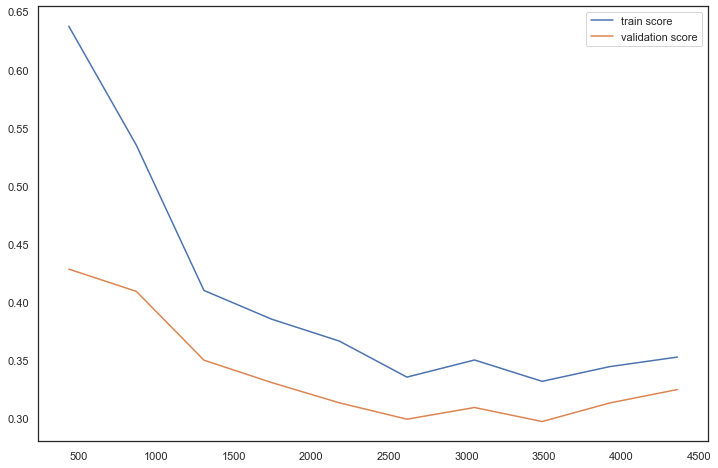

In [221]:
evaluation(model_1)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          740          207    947
Actual 1          239          269    508
TOTAL             979          476   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       947
         1.0       0.57      0.53      0.55       508

    accuracy                           0.69      1455
   macro avg       0.66      0.66      0.66      1455
weighted avg       0.69      0.69      0.69      1455



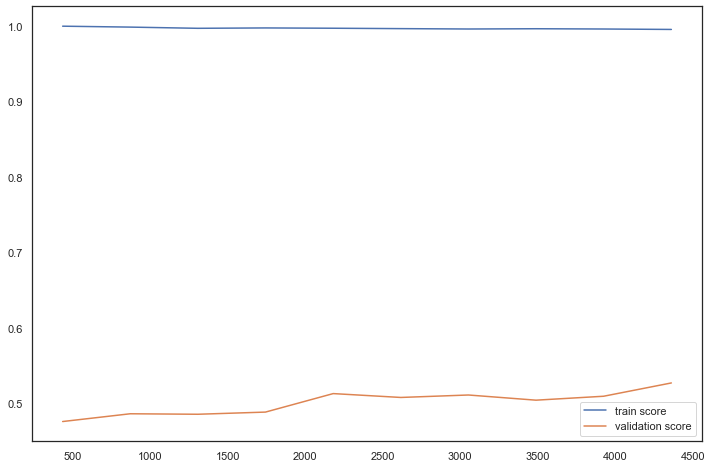

In [164]:
evaluation(model_2)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          849           98    947
Actual 1          254          254    508
TOTAL            1103          352   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       947
         1.0       0.72      0.50      0.59       508

    accuracy                           0.76      1455
   macro avg       0.75      0.70      0.71      1455
weighted avg       0.75      0.76      0.75      1455



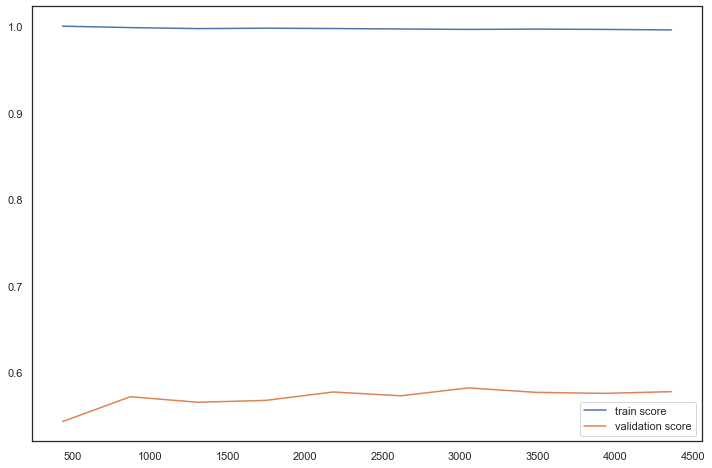

In [165]:
evaluation(model_3)

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          907           40    947
Actual 1          429           79    508
TOTAL            1336          119   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.68      0.96      0.79       947
         1.0       0.66      0.16      0.25       508

    accuracy                           0.68      1455
   macro avg       0.67      0.56      0.52      1455
weighted avg       0.67      0.68      0.61      1455



/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/marie/.pyenv/

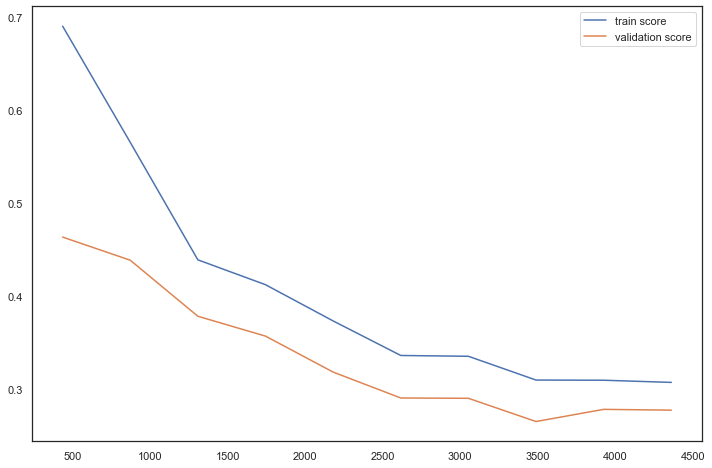

In [223]:
evaluation(model_4)

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          773          174    947
Actual 1          326          182    508
TOTAL            1099          356   1455

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76       947
         1.0       0.51      0.36      0.42       508

    accuracy                           0.66      1455
   macro avg       0.61      0.59      0.59      1455
weighted avg       0.64      0.66      0.64      1455



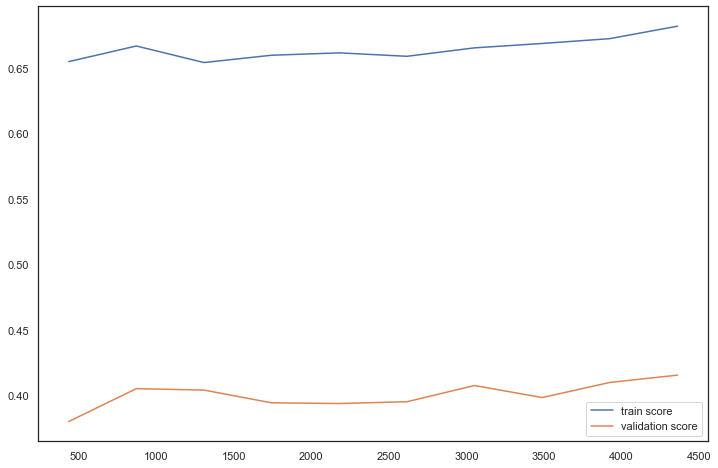

In [207]:
evaluation(model_5)

In [114]:
baseline = df.copy()
# sélection des colonnes à garder :
baseline = df[ratios_cols + target_col]

In [115]:
#baseline_0 : enlève toutes les lignes avec des NaN ou des infinis en plus
def imputation_v0(df):
    # Baseline 0 - suppression des lignes avec des NaN
    df = df.replace([np.inf, -np.inf], np.nan) # remplacement des infinis par des nan pour les supprimer aussi
    df = df.dropna(axis=0)
    return df

In [ ]:
len(baseline_1["Code APE"].value_counts())

In [ ]:
# encodage des variables catégorielles (on avait vu dans l'EDA quelles valeurs
# étaient prises, donc on peut le faire rapido à la main)

def encodage(df):
    # on crée un dictionnaire
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    # on l'applique aux cellules contenues dans les colonnes catégorielles
    # avec le .map
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [ ]:
def imputation(df):
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return  df

In [ ]:
# on commence le plus simplement par encodage et imputation, 

def preprocessing(df):
    
    df = encodage(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    # on garde un oeil sur la composition de la target
    print(y.value_counts())
    
    return X, y

### Gestion du reste des NaN et normalisation

In [ ]:
df["Taux VA"].isna().sum()

In [ ]:
1566+723+13

In [ ]:
for col in ratio
CA_null[col].value_counts()

# 1. Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
- Développer une premiere stratégie de modélisation 

## Checklist de base
#### Analyse de Forme :
- **variable target** : default (1 si défaillante, 0 sinon)
- **lignes et colonnes** : 9750, 130
- **types de variables** : quantitatives : 120, qualitatives : 10
- **Analyse des valeurs manquantes** :
    - très peu de NaN (2.47% au total). C'est normal vu que l'essentiel des données constituent des champs obligatoires de la déclaration fiscale. Et que si ces champs ne sont pas renseignés les valeurs ne sont pas considérées comme manquantes mais comme nulles. Pour les champs numériques obligatoires (CA, achats, stocks...) c'est le cas. Mais **pour d'autres (une grande partie des champs de la liste "general"), il faudra se pencher sur le nombre de zéros**.
    - NaN sur des infos complémentaires ("vrais" NaN) :
        - Catégorie juridique (Niveau I) => 91% de NaN / Se complète avec Catégorie juridique (Niveau II) => 9% de NaN => Il faudra probablement regrouper ces 2 colonnes en une seule, ou bien en supprimer les données. Provient d'une erreur dans la constitution de l'échantillon
        - Procédures collectives (type et date) : NaN pour 63% des entreprises, ce qui est normal car ne concerne que les entreprises en difficulté. Il faudra voir la meilleure façon de le prendre en compte
    - NaN sur les ratios (causés dans la plupart des cas par des valeurs nulles au dénominateur, à évaluer au cas par cas)
        - Poids des intérêts, taux de VA et taux d'EBE : On a 16% de NaN. Ces 3 ratios ayant en commun d'avoir le CA au dénominateur, il est probable que le CA soit nul pour 16% des entreprises. A creuser.
        - Poids des dettes fiscales : 13.9% de NaN. Devrait correspondre à des entreprises dont le total du bilan est nul ?
        
- **Entreprises avec un CA = 0**
    beaucoup de NaN (moitié des variables > 90% de NaN)
    - 2 groupes de données 76% -> Test viral, 89% -> taux sanguins

#### Analyse de Fond :
- **Visualisation de la target** :
    - 10% de positifs (558 / 5000)
    
    
    
- **Signification des variables** :
    -  variables continues standardisées, skewed (asymétriques), test sanguin
    - age quantile : difficile d'interpreter ce graphique, clairement ces données ont été traitées, on pourrait penser 0-5, mais cela pourrait aussi etre une transformation mathématique. On peut pas savoir car la personne qui a mit ce dataset ne le précise nul part. Mais ca n'est pas tres important
    - variable qualitative : binaire (0, 1), viral, Rhinovirus qui semble tres élevée



- **Relation Variables / Target** :
    - target / blood : les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 -> hypothese a tester
    - target/age : les individus de faible age sont tres peu contaminés ? -> attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit des enfants on sait que les enfants sont touchés autant que les adultes). En revanche cette variable pourra etre intéressante pour la comparer avec les résultats de tests sanguins
    - target / viral : les doubles maladies sont tres rares. Rhinovirus/Enterovirus positif - covid-19 négatif ? -> hypothese a tester ? mais il est possible que la région est subie une épidémie de ce virus. De plus on peut tres bien avoir 2 virus en meme temps. Tout ca n'a aucun lien avec le covid-19
    
    
    
## Analyse plus détaillée

- **Relation Variables / Variables** :
    - blood_data / blood_data : certaines variables sont tres corrélées : +0.9 (a suveiller plus tard)
    - blood_data / age : tres faible corrélation entre age et taux sanguins
    - viral / viral : influenza rapid test donne de mauvais résultats, il fauda peut-etre la laisser tomber
    - relation maladie / blood data : Les taux sanguins entre malades et covid-19 sont différents
    - relation hospitalisation / est malade : 
    - relation hospitalisation / blood : intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller


- **NaN analyse** : viral : 1350(92/8), blood : 600(87/13), both : 90

### hypotheses nulle (H0): 

- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents
    - H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs

- Les individus atteints d'une quelconque maladie ont des taux significativement différents


# Checklist n°2 - Personnalisée sur les 36 features sélectionnées
## Analyse d'ensemble
- NaN 
    - Suppression des lignes avec le CA null
    - 
- Variables qualitatives
    - Nombre de modalités
    - Etude de la relation de chaque variable à la target (violin/boxplot ? test statistique ?)
- Variables quantitatives
    - Analyse des distribitions => quelles transformations apporter ?
    - Identification des outliers
    - Identification des relations entre chacune des variables et la target
    - Identification des relations entre les variables entre elles (multicolinéarité)

In [170]:
eda = df.copy()
eda = eda[cols_to_keep]
eda.shape

(9750, 36)

In [171]:
eda.dtypes.value_counts()

float64    18
int64      15
object      3
dtype: int64

In [190]:
eda['A 10'].describe()

count     9750
unique      10
top         GI
freq      3428
Name: A 10, dtype: object

In [188]:
eda.describe()

Credit client  Credit Fournisseurs  Rotation_stocks             BFR             BFRE  Endettement total             CAF  Capacite de remboursement  Ressources durables              FRNG  Taux endettement  Rentabilite financiere             EBE              VA  Liquidite generale  Liquidite reduite  Taux ressources propres  Rentabilite des capitaux propres  Autonomie financiere  Poids interets    Taux EBE    Taux VA  Taux Rentabilite  Poids dettes fiscales  Taux augmentation endettement CT        Tresorerie    default  Age entreprise  Nombre de mois de l'exercice comptable 2016  TOTAL (I) (DL) 2016 (€)  Chiffre d'affaires net (Total) (FL) 2016 (€)  3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)  TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)
count     7448.00000           8176.00000       8181.00000      9750.00000       9750.00000         9750.00000      9750.00000                 7954.00000           9750.00000        9750.00000        9739.00000              9736.00000      9750.00000      9750.00000          9671.00000         9671.00000               9742.00000                        9736.00000            9742.00000      8163.00000  7448.00000 7448.00000        7448.00000             7448.00000                        9742.00000        9750.00000 9750.00000      9750.00000                                   9750.00000               9750.00000                                    9750.00000                                         9750.00000                                                               9750.00000
mean       149.06680            259.49268       -111.92346   1160261.44328    -138878.79138      1364773.25559    148485.69303                   10.52217        3324615.28954     6020446.86174           0.78049                 0.16303    165818.44913    816577.11969            16.47997           14.30006                -45.95842                           0.14836             -45.95735        -0.57668    -0.50258    0.00780           0.00476                0.12127                           0.00000     4860185.41846    0.34256       219.78256                                     12.03426            1870661.46667                                 4018868.68749                                        68601.07395                                                            4776372.49097
std       4192.35762           5622.41391      30906.21852  11703360.05793    5857346.67824     29139180.32587   5273915.50670                  804.05827       64021697.24436   124758383.08204          23.35833                12.01459   6176247.16704  10695116.76626           389.07610          375.79302               4484.90658                          11.88507            4484.90659        29.69118    16.96251   13.79397          31.32679                2.89680                           0.00000   123433172.43328    0.47459       176.58743                                      0.72275           39104226.60941                               103138110.53327                                      4821236.84063                                                           68009461.46059
min         -0.39193         -12816.89876   -2650121.10577 -77080925.00000 -332866000.00000         -744.00000 -45609000.00000               -15558.33333    -1012887273.00000 -1012887273.00000       -1032.13333              -903.55102 -25508513.00000 -23264764.00000           -13.59083           -6.06870            -442652.81481                        -903.55102         -442652.81481     -2494.10938 -1103.89953 -944.98075        -903.12199               -0.00961                           0.00000 -1012887273.00000    0.00000        35.00000                                      1.00000        -1012887273.00000                                       0.00000                                    -79799577.00000                                                        -1001350437.00000
25%          2.85627             26.07302          0.00000      9179.25000   

### NaN

- Au total 5,5% de valeurs manquantes à l'échelle du dataset. 
- Un premier tour de visualisation des NaN permet d'identifier des strates où ils se concentrent. Il s'agit essentiellement de ratios, et c'est lié à la présence de CA nulls dans l'échantillon. 


**Focus sur les entreprises avec un CA null**
- 2302 entreprises avec CA null (1541 saines et 761 défaillantes)
- Est-ce pertinent de garder ces entreprises ? Comment reformuler cette question ? 
    - Est ce que la distribution (entre des entreprises ayant un CA nul et celle n'en ayant pas est significativement différente ?
    
- En supprimant les entreprises affichant un CA null, 
    - on voit bien que le taux de NaN diminue fortement : on passe de 5,5% à 0,36%.
    - la colonne "tranche d'effectifs" est à 10% de valeurs nulles.
    - le reste est de 1% et moins => on pourra imputer, la façon de le faire sera déterminée au cas par cas après étude des données
    - validation de la suppression des lignes avec CA null => on voit que ça ne change pas la part des entreprises saines et défaillantes. Economiquement ca fait aussi du sens de supprimer ces entreprises


In [178]:
# pour que les valeurs infinies soient considérées aussi comme des NaN :
pd.options.mode.use_inf_as_na = True

In [180]:
eda.columns

Index(['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 'Endettement total', 'CAF', 'Capacite de remboursement', 'Ressources durables', 'FRNG', 'Taux endettement', 'Rentabilite financiere', 'EBE', 'VA', 'Liquidite generale', 'Liquidite reduite', 'Taux ressources propres', 'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Taux augmentation endettement CT', 'Tresorerie', 'default', 'Age entreprise', 'Tranche effectifs', 'Nombre de mois de l'exercice comptable 2016', 'TOTAL (I) (DL) 2016 (€)', 'Chiffre d'affaires net (Total) (FL) 2016 (€)', '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)', 'A 21', 'A 10'], dtype='object')

<AxesSubplot:>

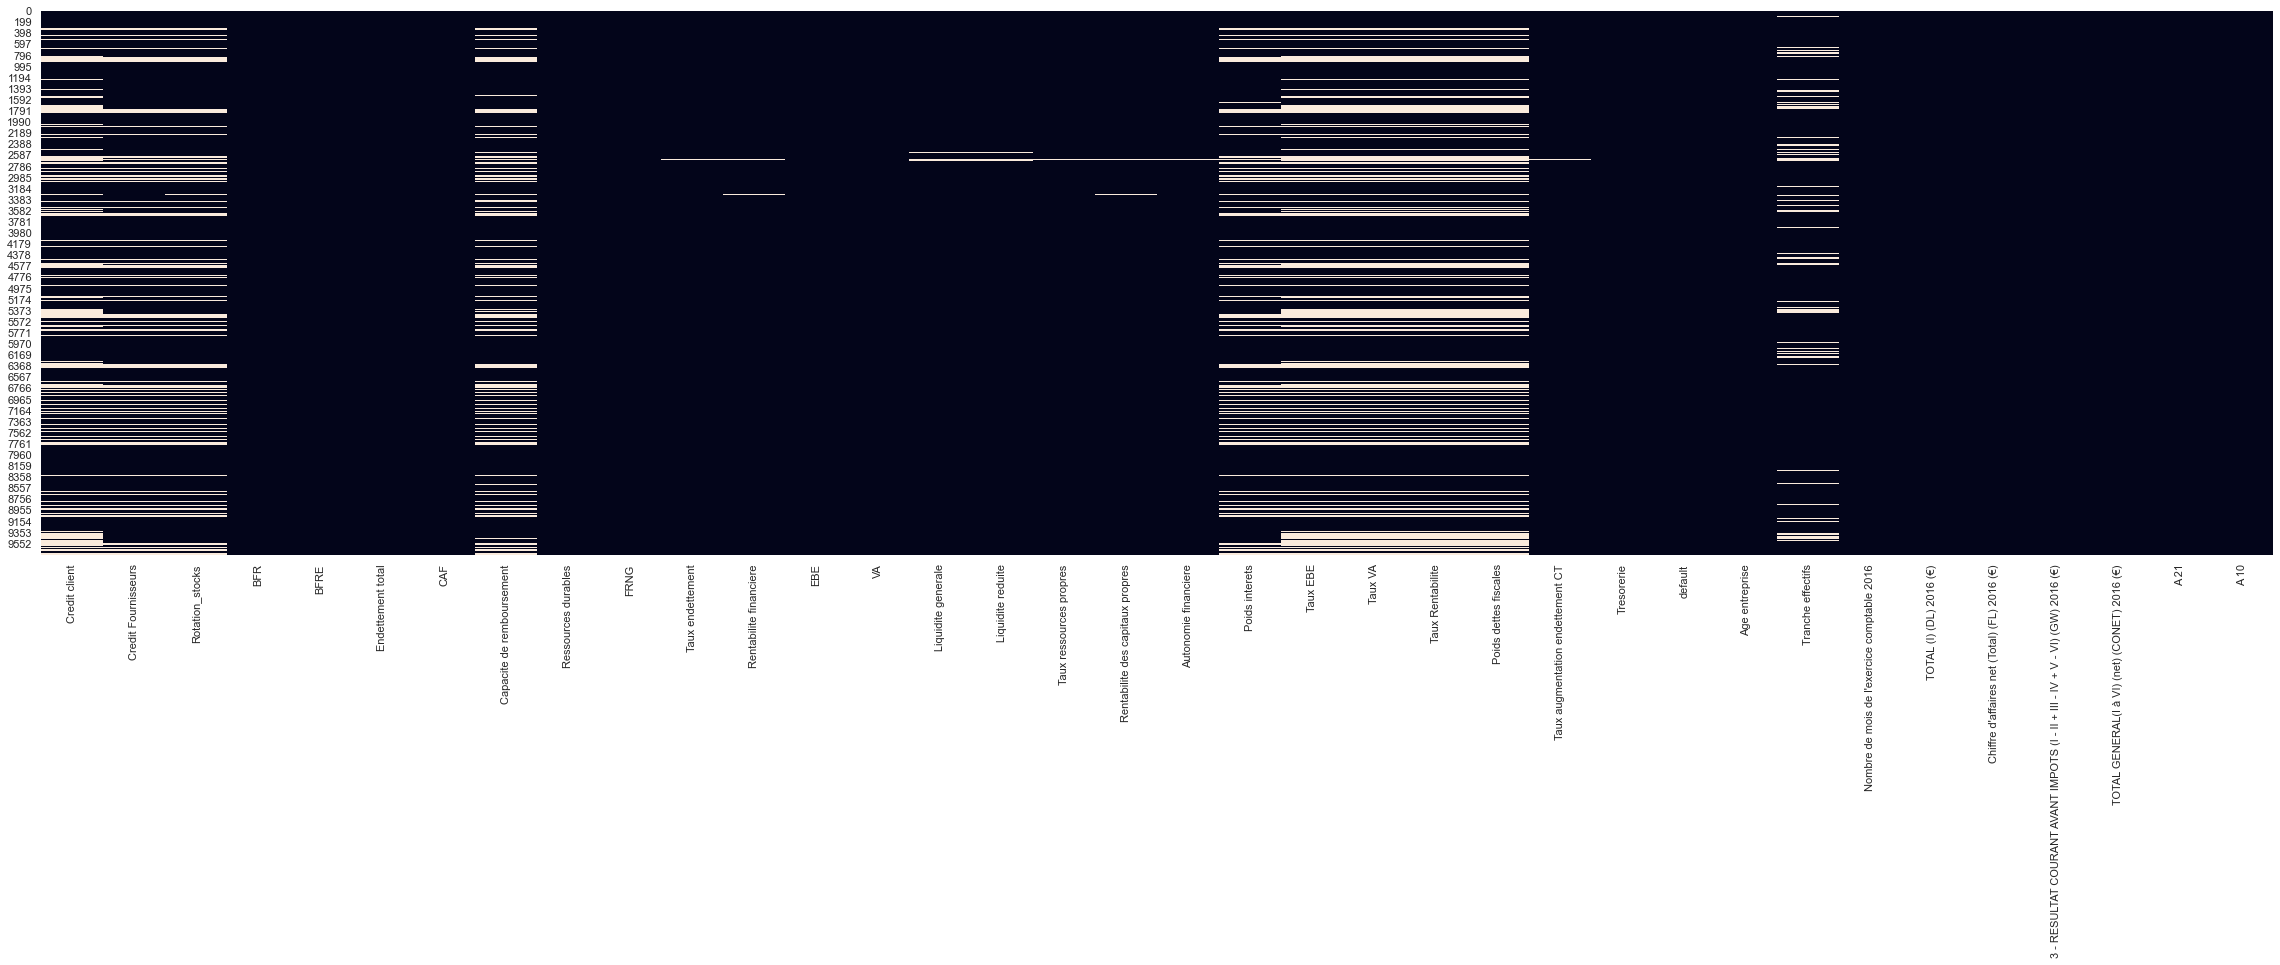

In [179]:
# heatmap des valeurs manquantes (en blanc)
plt.figure(figsize=(40,10))
sns.heatmap(eda.isna(), cbar=False)

In [276]:
eda2 = eda[eda["Chiffre d'affaires net (Total) (FL) 2016 (€)"] != 0]

In [277]:
eda2.shape

(7448, 36)

<AxesSubplot:>

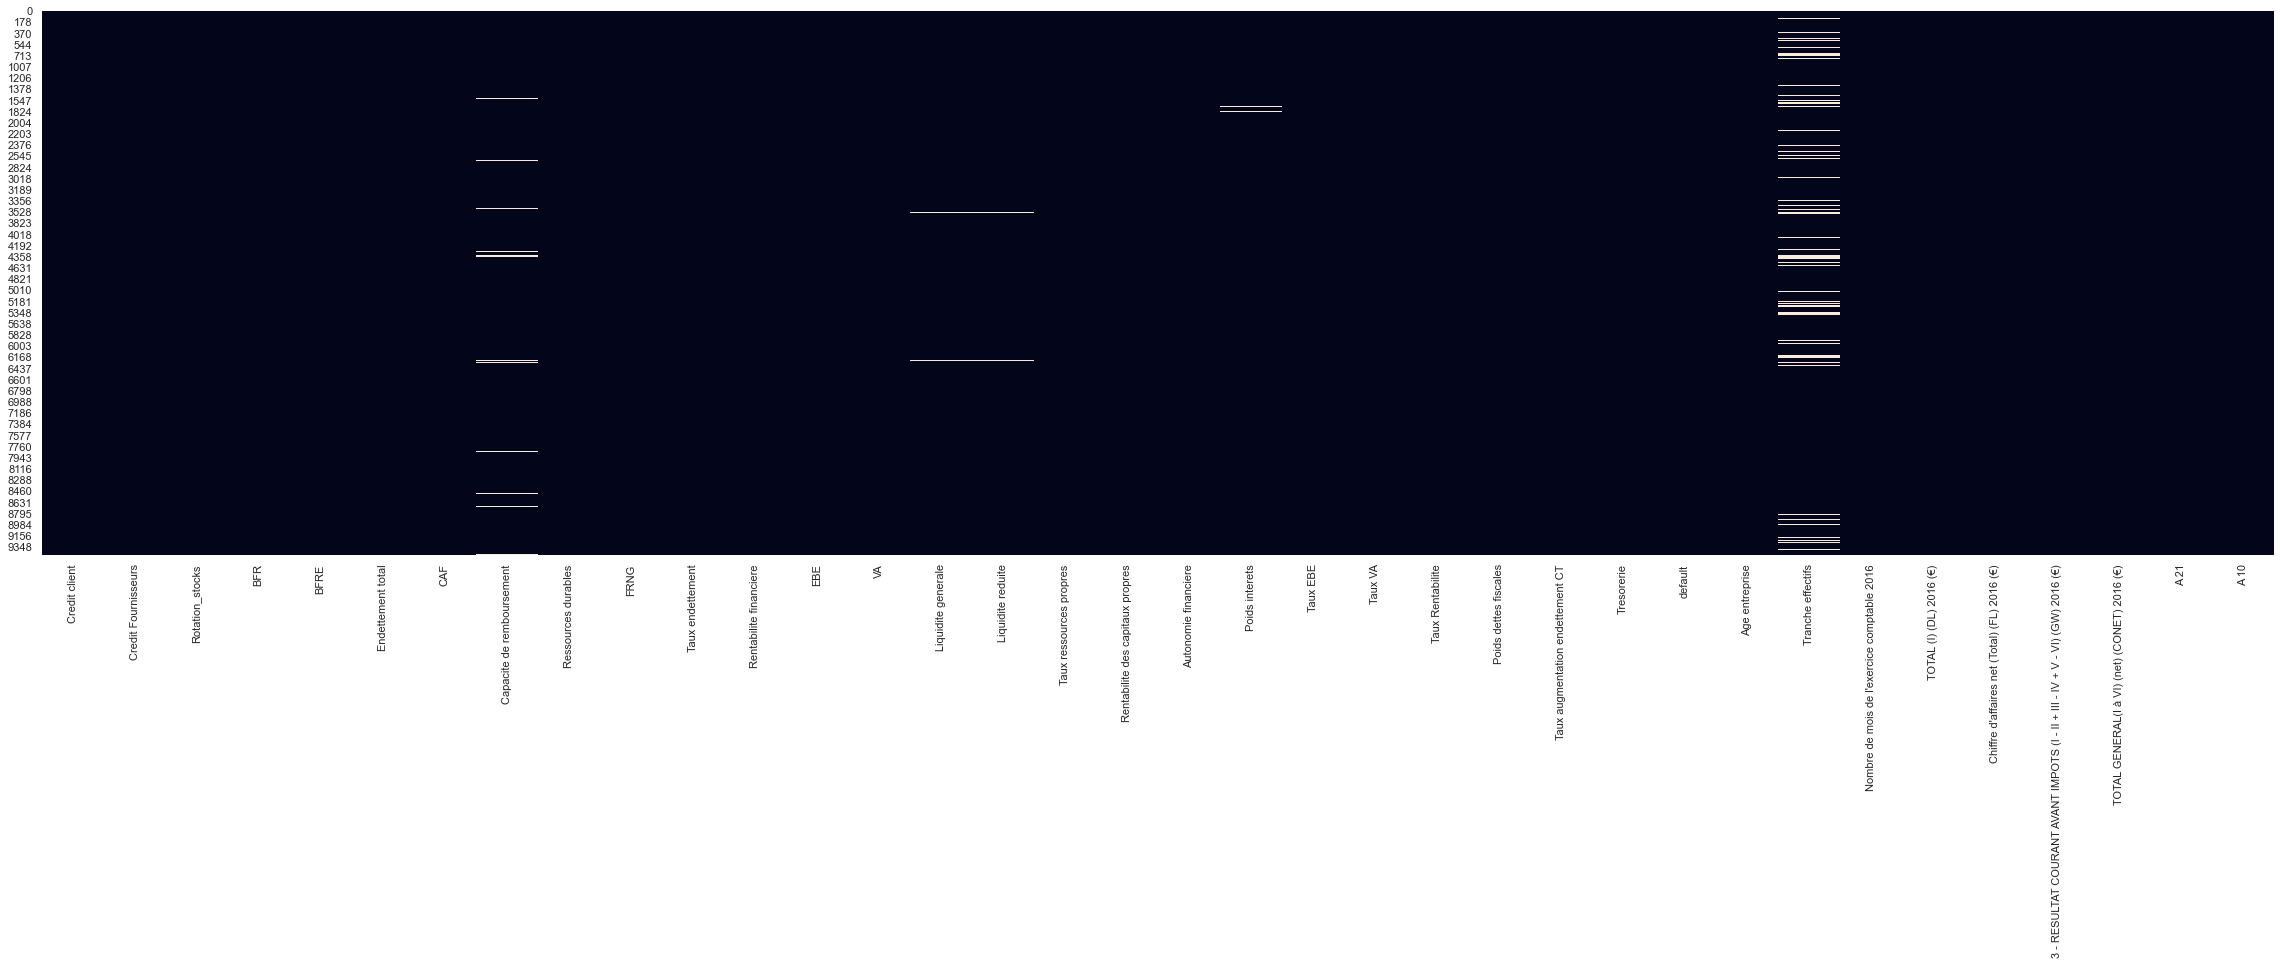

In [183]:
# heatmap des valeurs manquantes (en blanc) une fois les lignes avec CA null supprimées
plt.figure(figsize=(40,10))
sns.heatmap(eda2.isna(), cbar=False)

In [184]:
# total de NaN sur le dataset
eda.isna().sum().sum()/(eda.shape[0]*eda.shape[1])*100

5.5547008547008545

In [185]:
# taux de NaN par colonne
(eda.isna().sum()/eda.shape[0]).sort_values(ascending=False)

Credit client                                                                  0.23610
Poids dettes fiscales                                                          0.23610
Taux Rentabilite                                                               0.23610
Taux VA                                                                        0.23610
Taux EBE                                                                       0.23610
Capacite de remboursement                                                      0.18421
Poids interets                                                                 0.16277
Credit Fournisseurs                                                            0.16144
Rotation_stocks                                                                0.16092
Tranche effectifs                                                              0.12718
Liquidite generale                                                             0.00810
Liquidite reduite                          

In [186]:
# total de NaN sur le dataset
eda2.isna().sum().sum()/(eda2.shape[0]*eda.shape[1])*100

0.36400525122329636

In [187]:
# taux de NaN par colonne
(eda2.isna().sum()/eda2.shape[0]).sort_values(ascending=False)

Tranche effectifs                                                              0.10043
Capacite de remboursement                                                      0.01853
Liquidite reduite                                                              0.00363
Liquidite generale                                                             0.00363
Poids interets                                                                 0.00242
Credit Fournisseurs                                                            0.00107
Rentabilite financiere                                                         0.00040
Rentabilite des capitaux propres                                               0.00040
Taux endettement                                                               0.00013
Taux ressources propres                                                        0.00013
Autonomie financiere                                                           0.00013
Taux augmentation endettement CT           

In [ ]:
# qq plot
from scipy import stats
import seaborn as sns
for col in eda2.select_dtypes('number'):
    plt.figure()
    stats.probplot(df[col], plot=sns.mpl.pyplot)

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

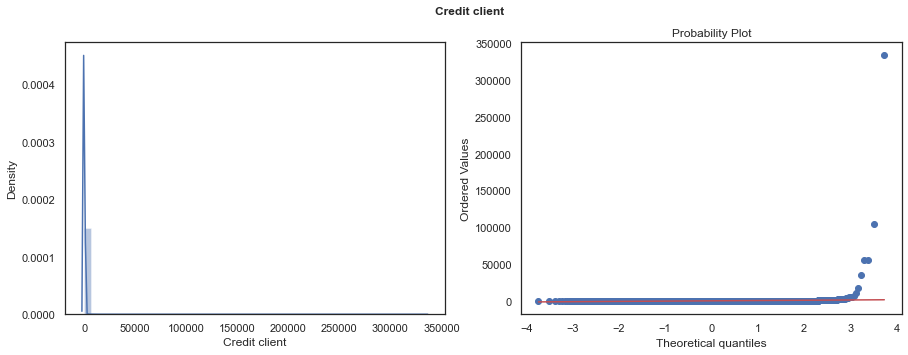

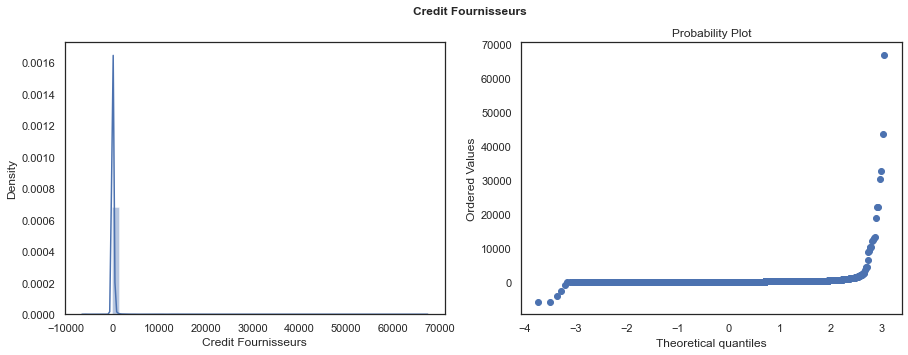

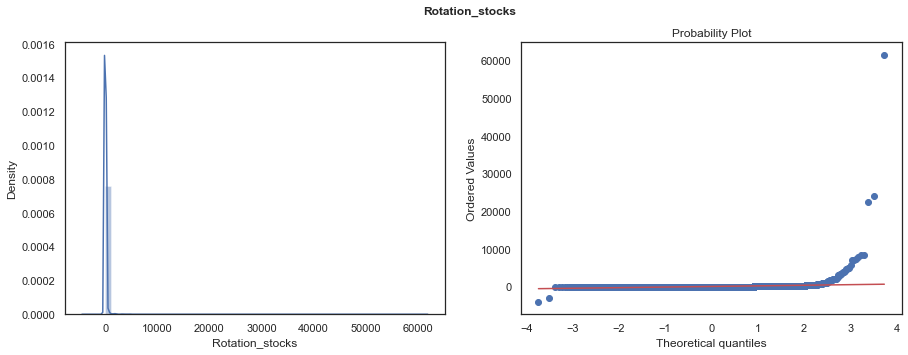

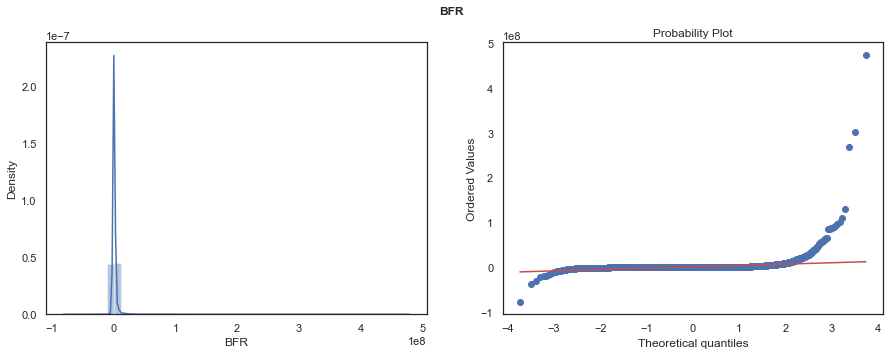

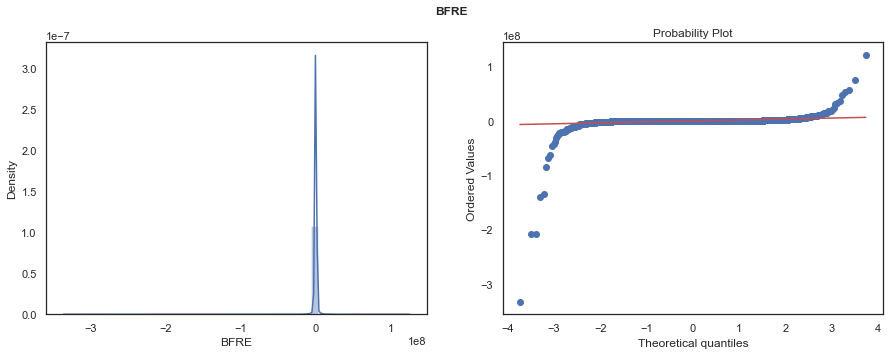

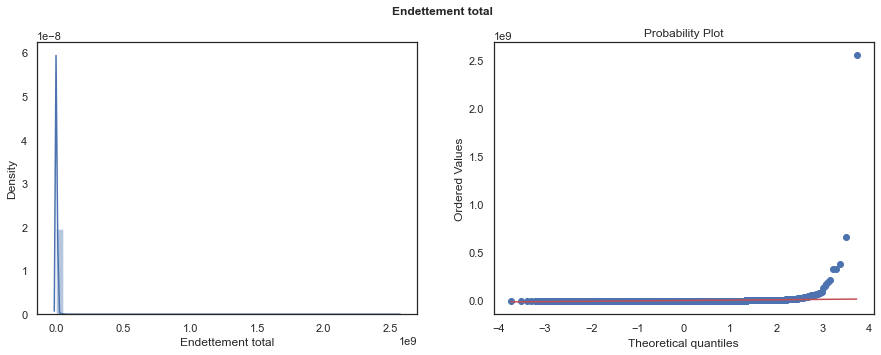

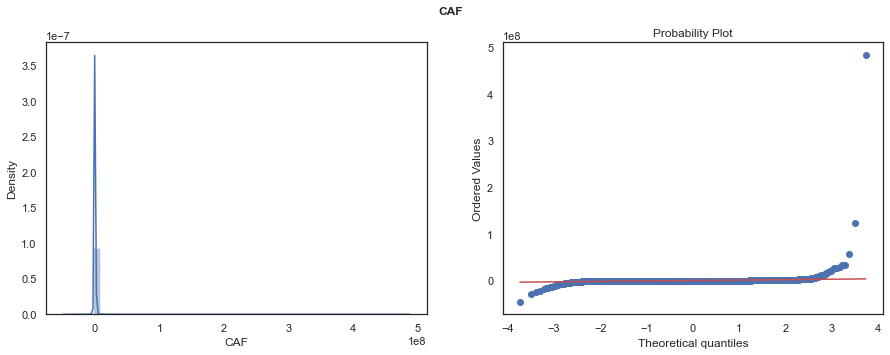

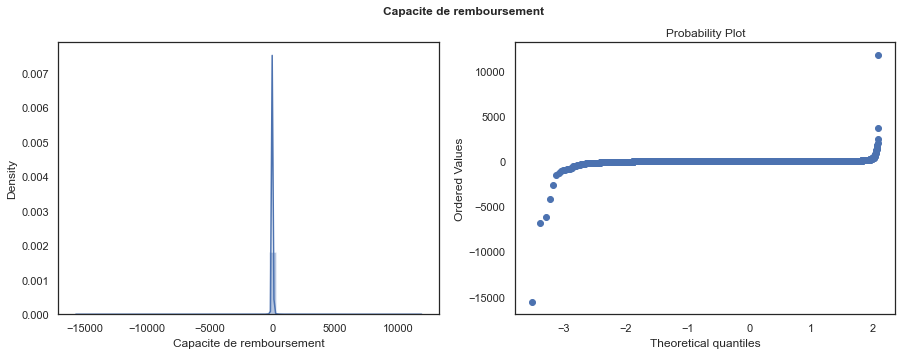

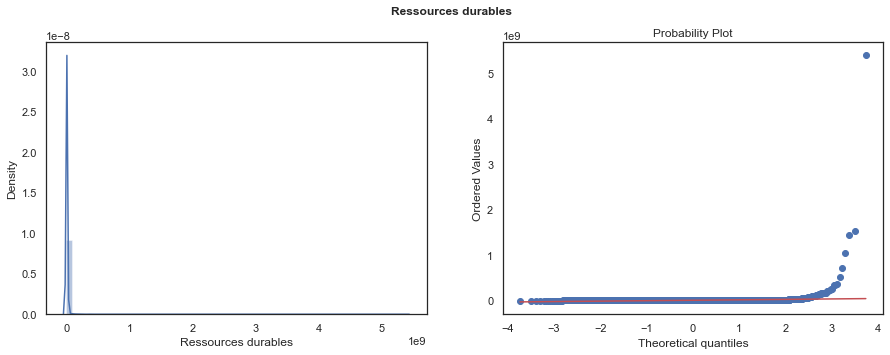

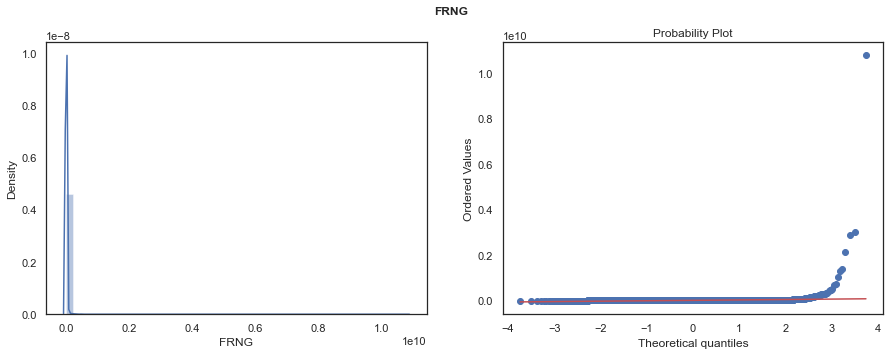

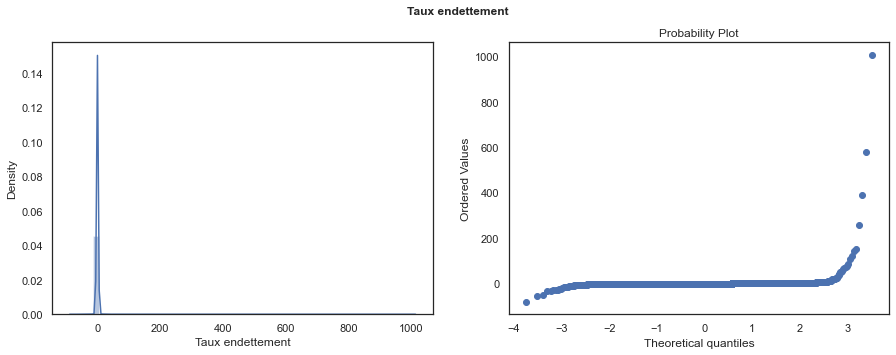

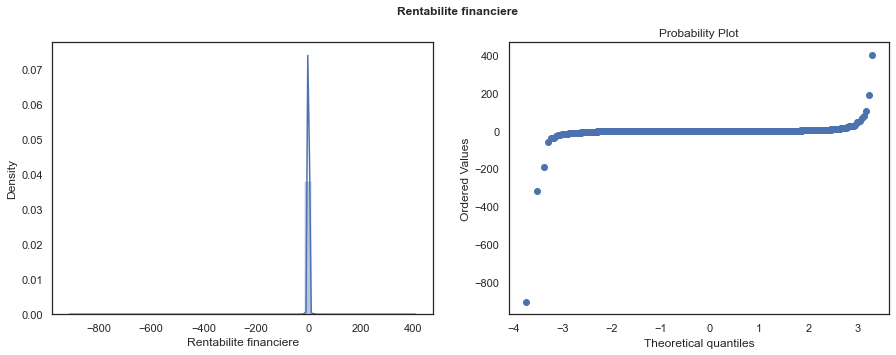

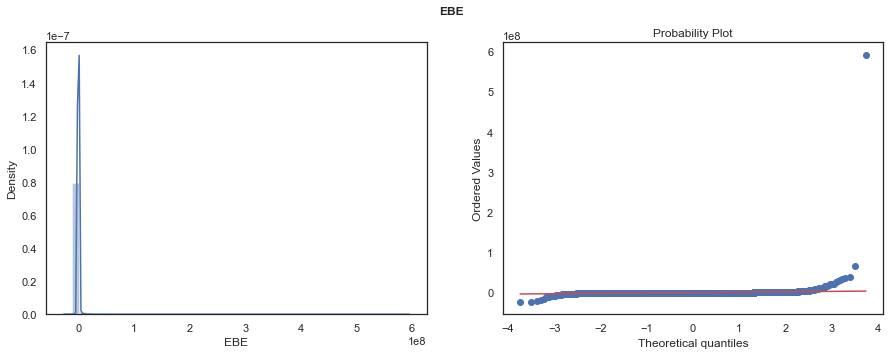

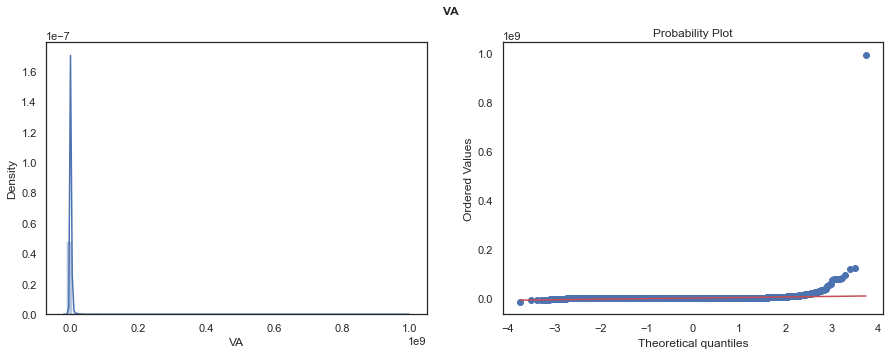

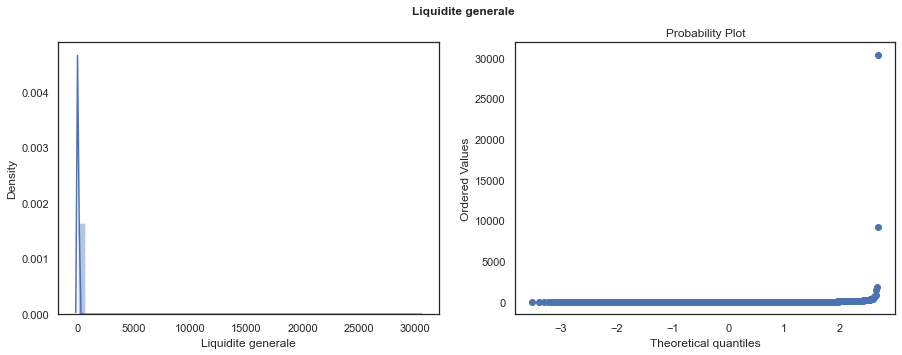

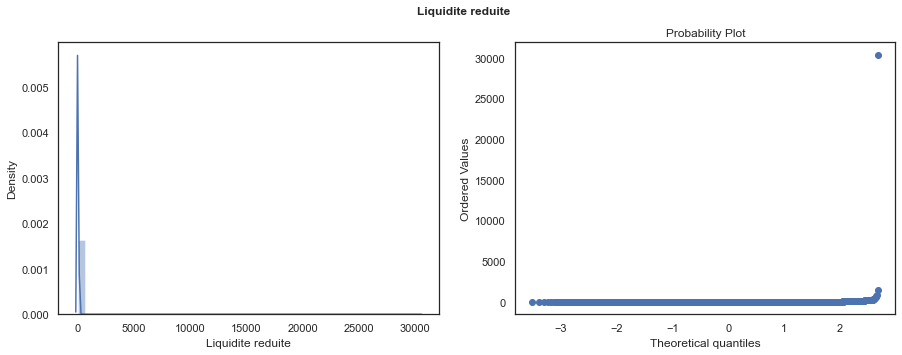

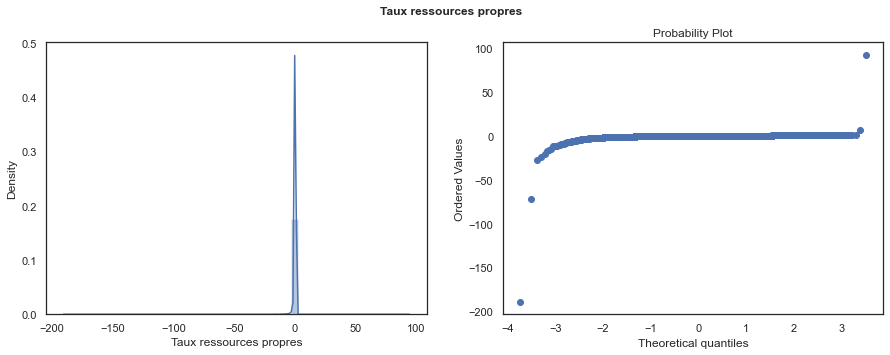

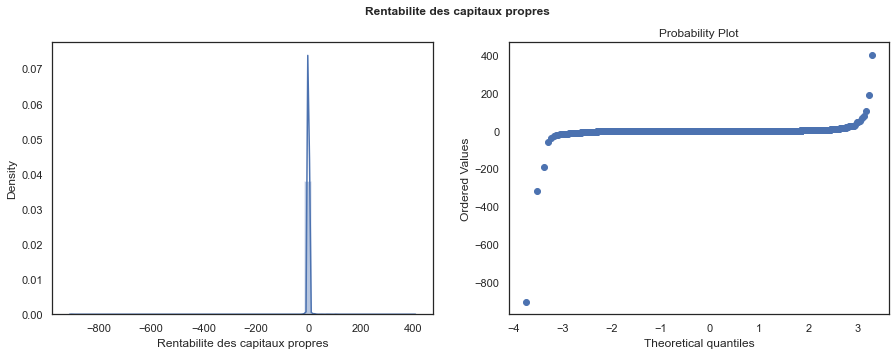

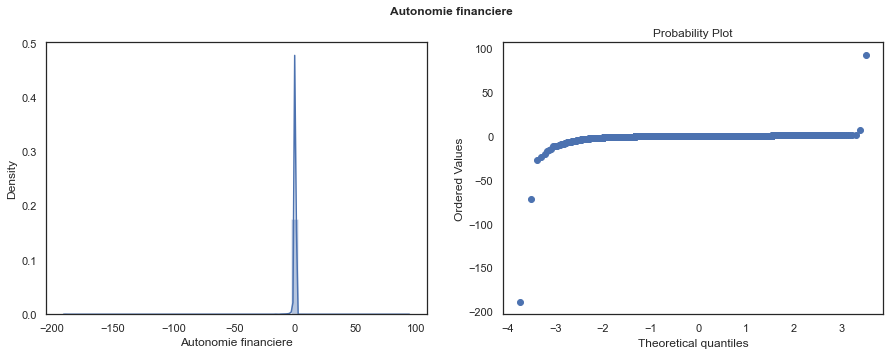

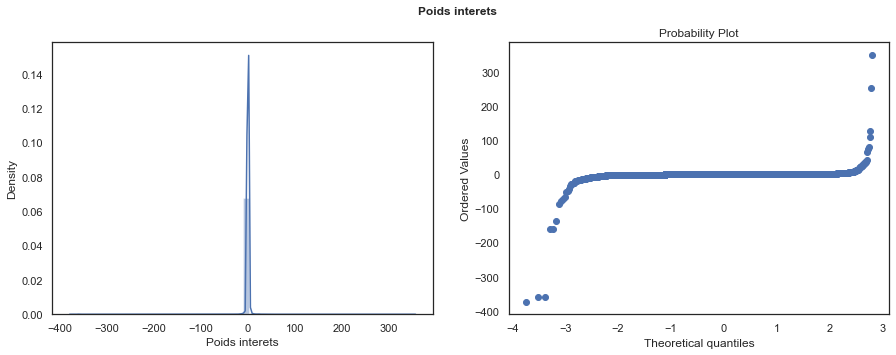

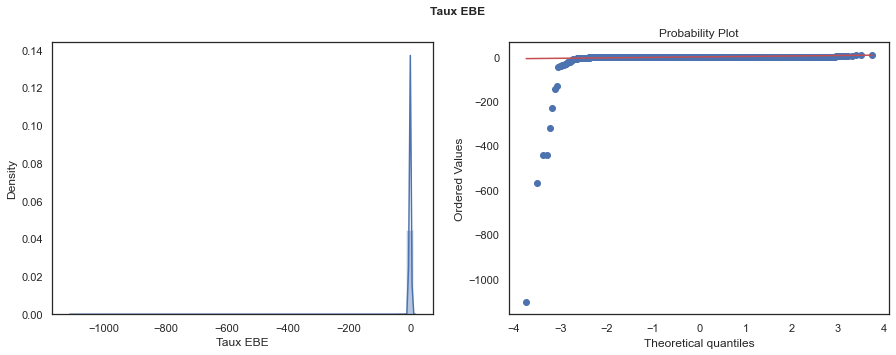

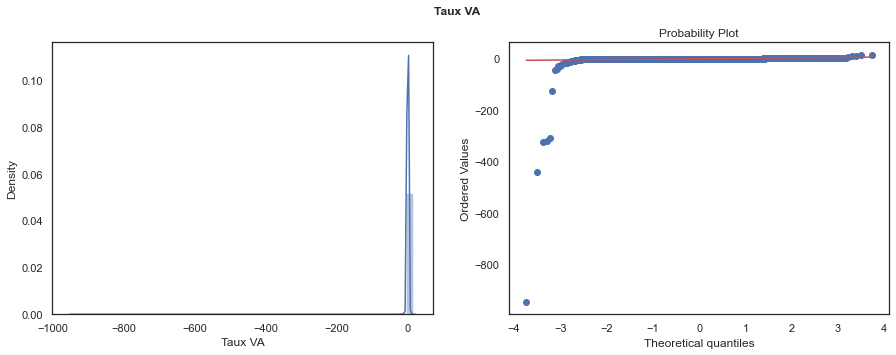

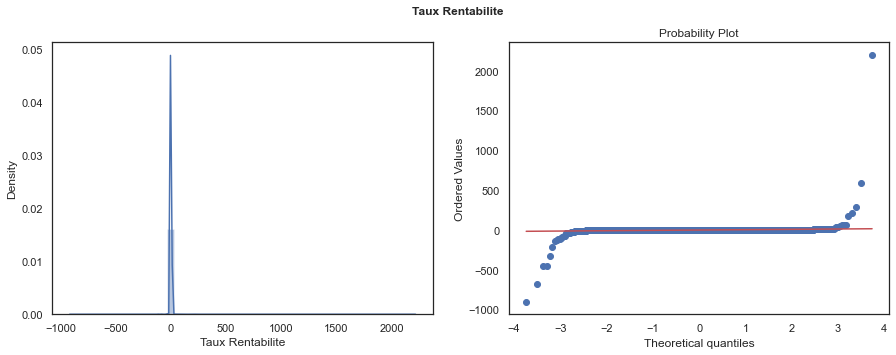

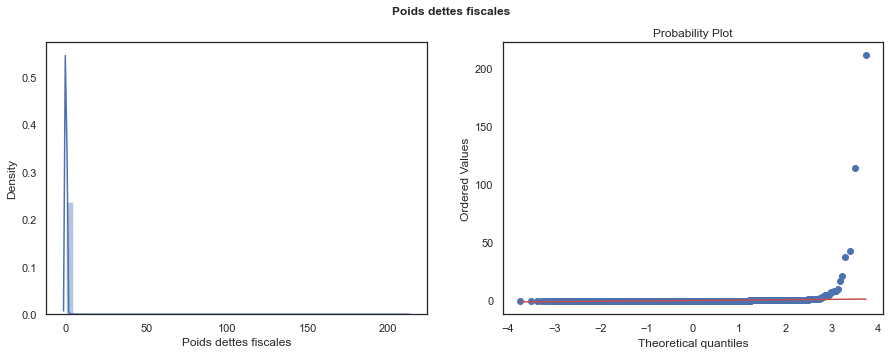

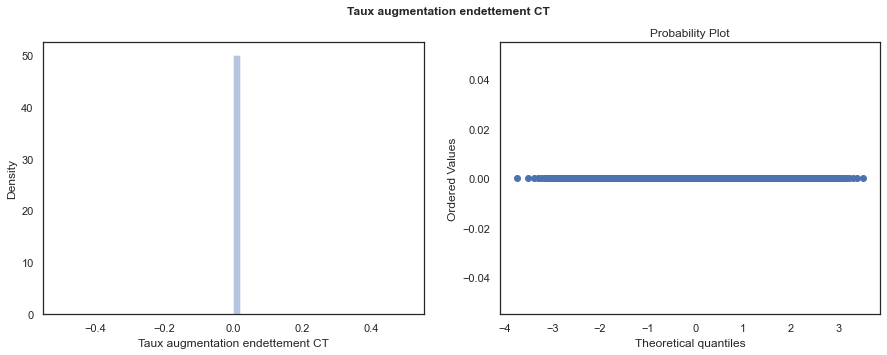

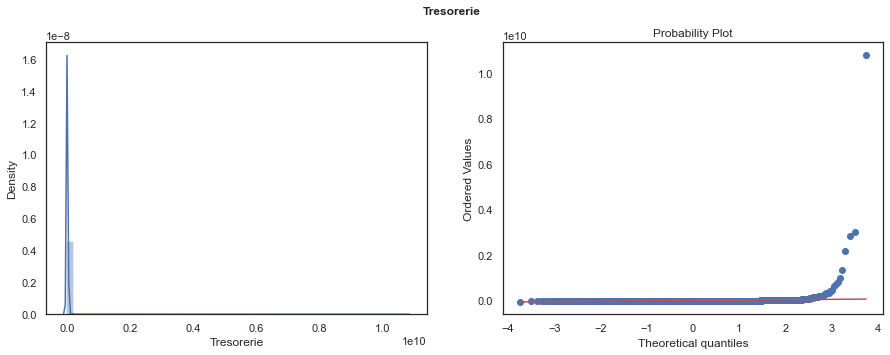

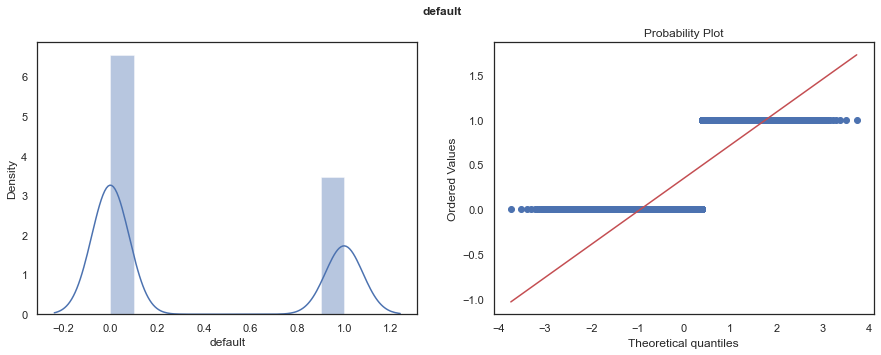

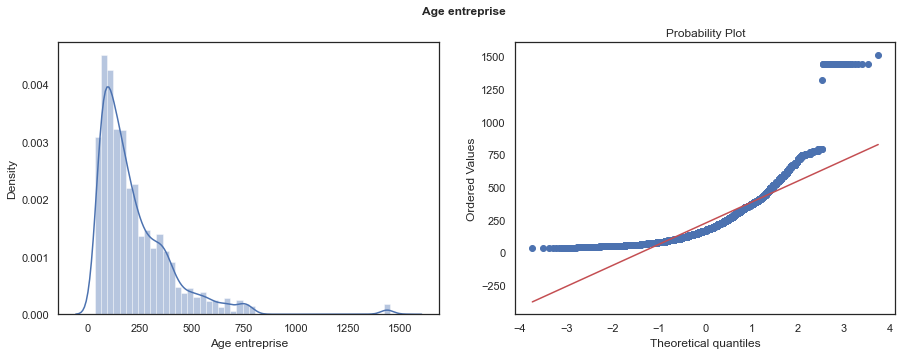

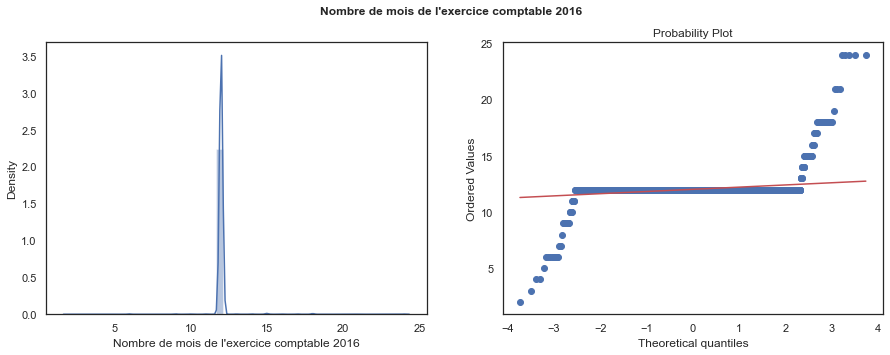

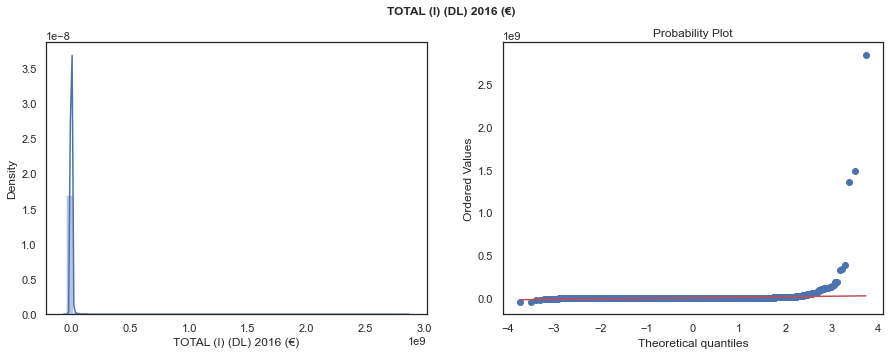

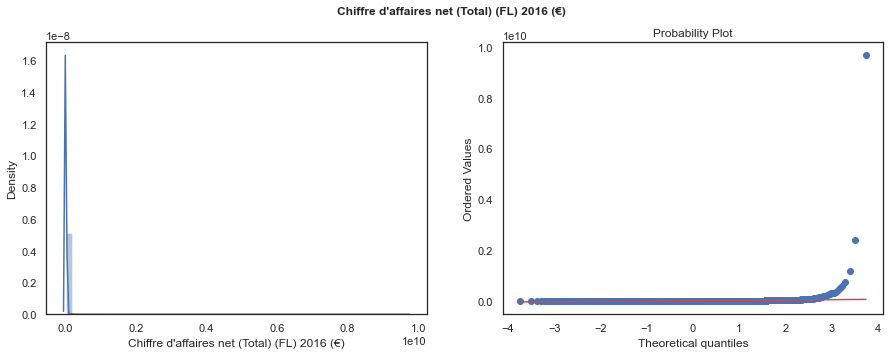

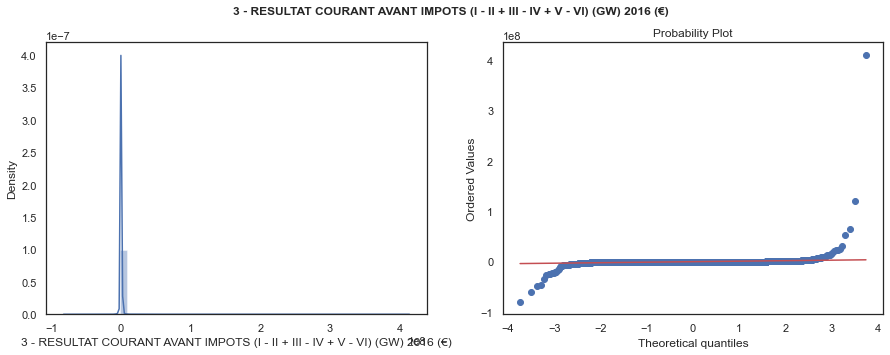

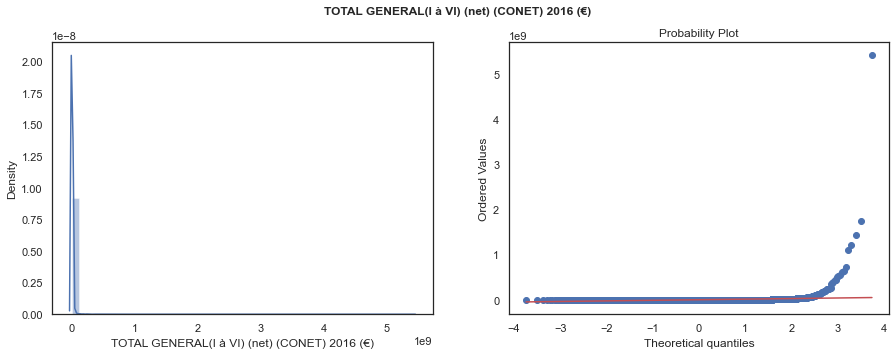

In [199]:
# Histogramme des variables continues
from scipy import stats

for col in eda2.select_dtypes('number'):
    fig, ((axe1,axe2)) = plt.subplots(nrows=1,ncols=2, figsize = (15,5))
    fig.suptitle(f'{col}', fontsize=12,fontweight="bold")
    
    #sns.histplot(data=eda2, x=col, ax=axe1)
    sns.distplot(eda2[col], ax=axe1)
    #axe1.set_title('Distribution',fontstyle='italic',fontsize= font_size_title)
    #axe1.set_xlabel('Montant du tips en $', fontsize= font_size_axis)
    #axe1.set_ylabel('Nombre de tips', fontsize= font_size_axis)
    
    stats.probplot(eda2[col], plot=sns.mpl.pyplot)
    #axe1.set_title('QQ-plot',fontstyle='italic',fontsize= font_size_title)

    
    #plt.figure()
    #sns.distplot(eda2[col])
    #sns.
    # rajouter qq plot
    # rajouter lien avec la target ?

## Supprimer les outliers ?
### De façon non discriminée

In [ ]:
''' Detection '''
# IQR
Q1 = np.percentile(df_boston['DIS'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_boston['DIS'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df_boston.shape)
 
# Upper bound
upper = np.where(df_boston['DIS'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_boston['DIS'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df_boston.drop(upper[0], inplace = True)
df_boston.drop(lower[0], inplace = True)
 
print("New Shape: ", df_boston.shape)

In [248]:
# IQR
def remove_outliers(df):
    for col in df.select_dtypes(np.number):
        print("Start shape : ", df.shape)
        Q1 = np.percentile(df[col], 25,
                           interpolation = 'midpoint')
        Q3 = np.percentile(df[col], 75,
                           interpolation = 'midpoint')
        IQR = Q3 - Q1
        # Upper bound
        upper = np.where(df[col] >= (Q3+1.5*IQR))
        # Lower bound
        lower = np.where(df[col] <= (Q1-1.5*IQR))
        # Removing outliers
        df = df.drop(index=upper[0])
        #df = df.drop(index=lower[0])
        print("End shape : ", df.shape)
    return df

In [272]:
# (modified from http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)
def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.75) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text(df_in, col_name):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values(df_in, col_name)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    print("Montant minimum --> ", minimum)
    print("Nb minimum --> ", df_in.loc[(df_in[col_name] <= minimum)].shape[0])
    print("Montant maximum --> ",maximum)
    print("Nb maximum --> ", df_in.loc[(df_in[col_name] >= maximum)].shape[0])
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

def box_and_whisker(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

In [273]:
for col in eda2.select_dtypes(np.number):
    print(f"{col} has {count_outliers(eda2, col)} outliers")

Montant minimum -->  -100.41959427538796
Nb minimum -->  0
Montant maximum -->  174.98271339387952
Nb maximum -->  513
Credit client has 513 outliers
Montant minimum -->  -63.14523515457158
Nb minimum -->  8
Montant maximum -->  173.96648277132525
Nb maximum -->  657
Credit Fournisseurs has 665 outliers
Montant minimum -->  -47.00532636640287
Nb minimum -->  2
Montant maximum -->  78.34221061067144
Nb maximum -->  881
Rotation_stocks has 883 outliers
Montant minimum -->  -821743.0
Nb minimum -->  131
Montant maximum -->  1392543.0
Nb maximum -->  1010
BFR has 1141 outliers
Montant minimum -->  -307888.75
Nb minimum -->  930
Montant maximum -->  233189.25
Nb maximum -->  833
BFRE has 1763 outliers
Montant minimum -->  -409345.125
Nb minimum -->  0
Montant maximum -->  686151.875
Nb maximum -->  1084
Endettement total has 1084 outliers
Montant minimum -->  -112732.875
Nb minimum -->  485
Montant maximum -->  187648.125
Nb maximum -->  968
CAF has 1453 outliers
Montant minimum -->  -5.182

In [275]:
for col in eda2.select_dtypes(np.number):
    eda2 = remove_outliers(eda2, col)
    print(eda2.shape[0])
    

6935
6390
5696
4854
4047
3511
3047
2386
2231
2121
1917
1763
1674
1531
1371
1318
1225
1219
1213
880
806
804
769
0
0
0
0
0
0
0
0
0
0


## Je tente de tout passer en log 
Raisons : les distributions ne sont pas normales
Elles sont surtout fortement asymétriques vers les valeurs hautes. Donc je tente de réduire cette asymétrie avec de log, car sinon j'ai des "outliers" au sens de l'Intervalle inter quartile qui, si je les supprime, me vident 100% de mes données
- Trouver une transformation permettant d'écraser les queues de distribution pour diminuer le nombre d'outliers, et 
- Vérifier ca avec le test rapide des modèles pour voir si ca change quelque chose sur les scores

**Premier essai : un passage de tout le dataset en log.**
- Une fois la transformation en log de faite, j'ai toujours des différences sur les qq plots mais les distplots semblent plus lisibles et ressemblent quand même plus à des lois normales.
- Quand je refais les calculs d'outliers, j'aboutis à peu de valeurs sur la tranche du haut.
- Problème : trop de valeurs nulles et négatives, non prises en charge par le log. Ainsi on a 100% du dataset "out" si on enlève les nan.On a plus de la moitié des colonnes qui dépassent les 16% de NaN.

**Deuxième essai : un passage de tout le dataset en racine carrée**
- Essai de passer en racine carrée. C'est mieux mais, ne prenant pas en charge les valeurs négatives, on a là encore beaucoup de colonnes affichant trop de NaN.

**Quelle solution ? Faut-il vraiment s'inquiéter des "outliers"**
Peut-etre autant de valeurs "extrêmes" car on n'est pas du tout dans le cadre d'une loi normale et qu'il ne faut pas chercher à y rentrer ?
Peut-être que mes données sont très mauvaises ?



### Premier essai : un passage de tout le dataset en log.

In [279]:
eda2_num = eda2.select_dtypes(np.number)

In [286]:
eda_log = np.log(eda2_num)

In [287]:
eda_log.shape

(7448, 33)

In [282]:
for col in eda_log.columns:
    print(f"{col} has {count_outliers(eda_log, col)} outliers")

Montant minimum -->  0.38529661370183543
Nb minimum -->  1657
Montant maximum -->  6.817595507625671
Nb maximum -->  44
Credit client has 1701 outliers
Montant minimum -->  1.5984130914277208
Nb minimum -->  447
Montant maximum -->  6.18823805123934
Nb maximum -->  143
Credit Fournisseurs has 590 outliers
Montant minimum -->  -1.4176774663989267
Nb minimum -->  2882
Montant maximum -->  7.410961240521609
Nb maximum -->  39
Rotation_stocks has 2921 outliers
Montant minimum -->  6.903429409425001
Nb minimum -->  50
Montant maximum -->  17.648950507278165
Nb maximum -->  26
BFR has 76 outliers
Montant minimum -->  5.795626214851243
Nb minimum -->  40
Montant maximum -->  16.852972778256817
Nb maximum -->  9
BFRE has 49 outliers
Montant minimum -->  4.897790015914624
Nb minimum -->  1503
Montant maximum -->  17.65468175733097
Nb maximum -->  26
Endettement total has 1529 outliers
Montant minimum -->  5.019777647215844
Nb minimum -->  203
Montant maximum -->  15.75879151610346
Nb maximum --

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

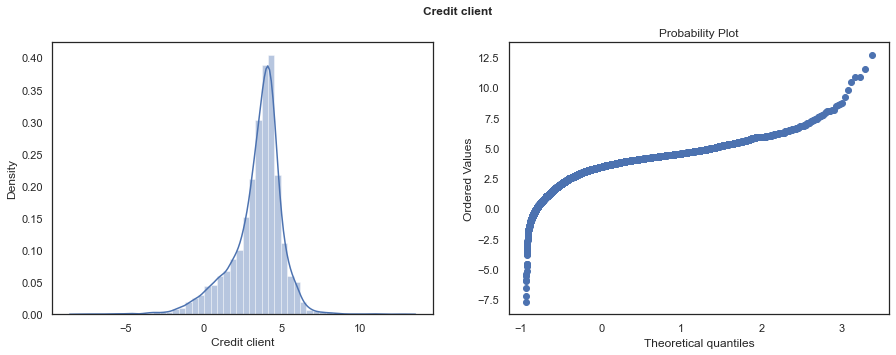

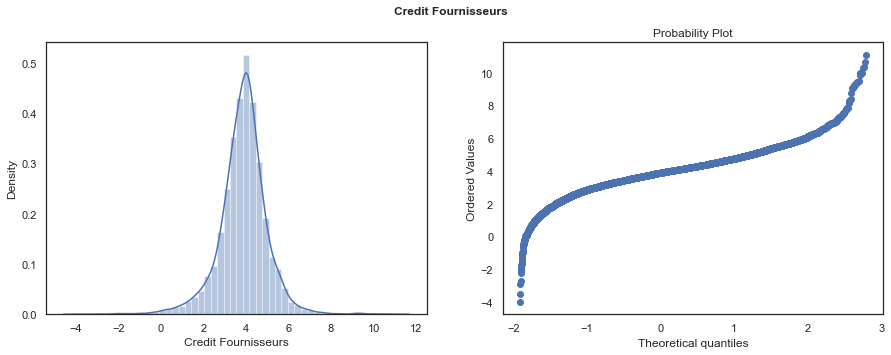

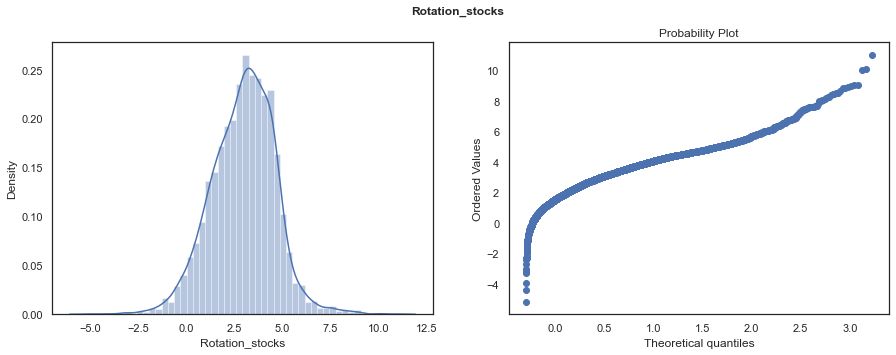

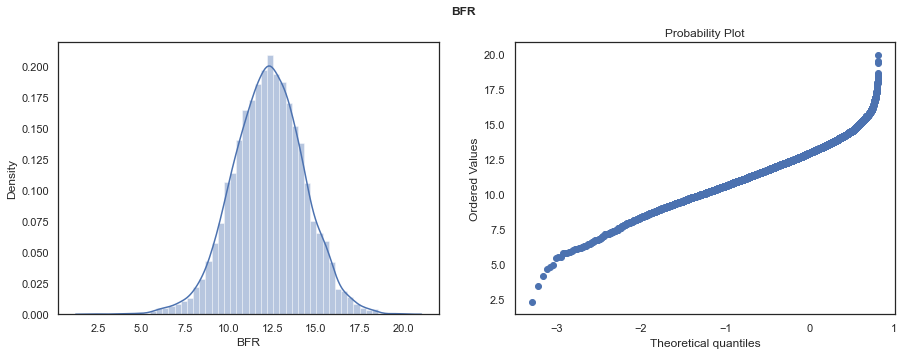

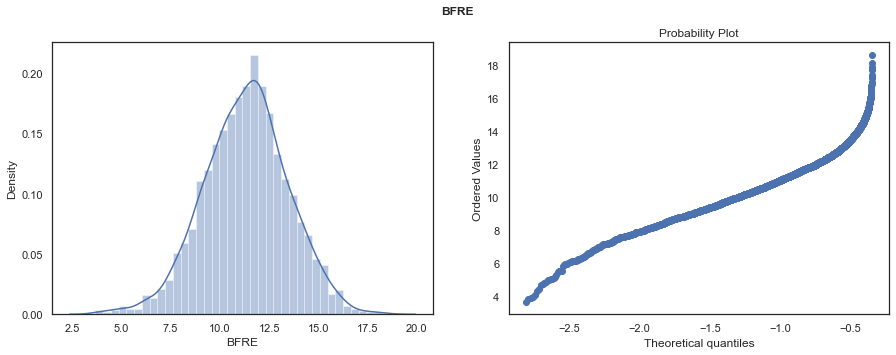

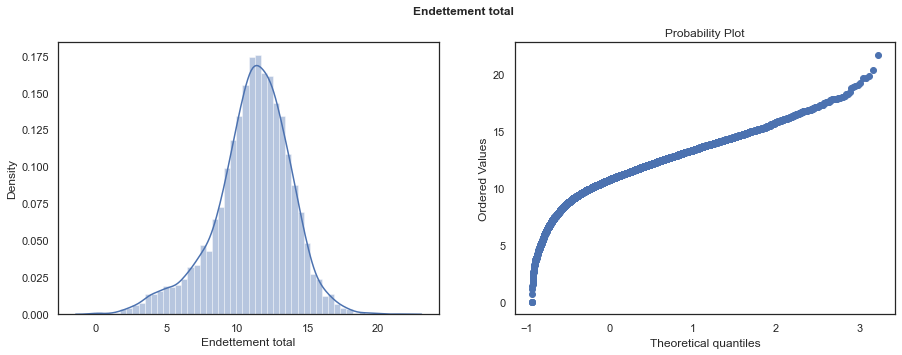

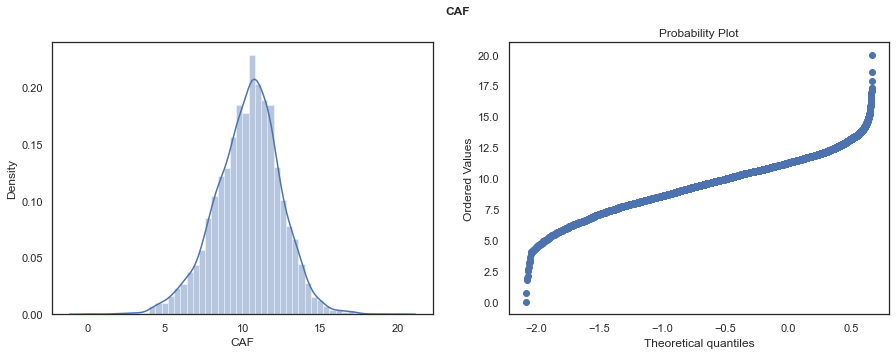

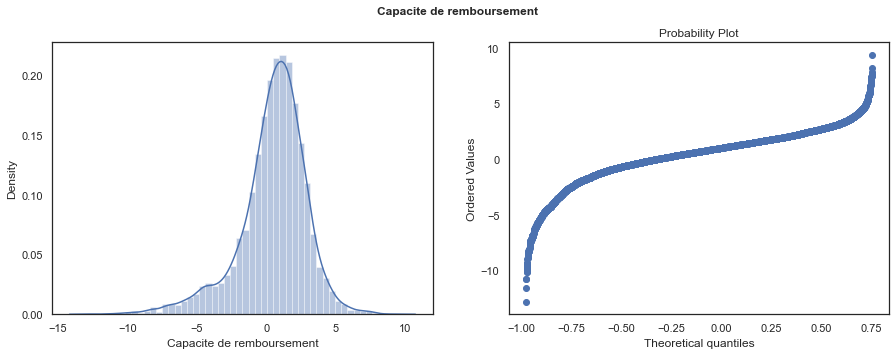

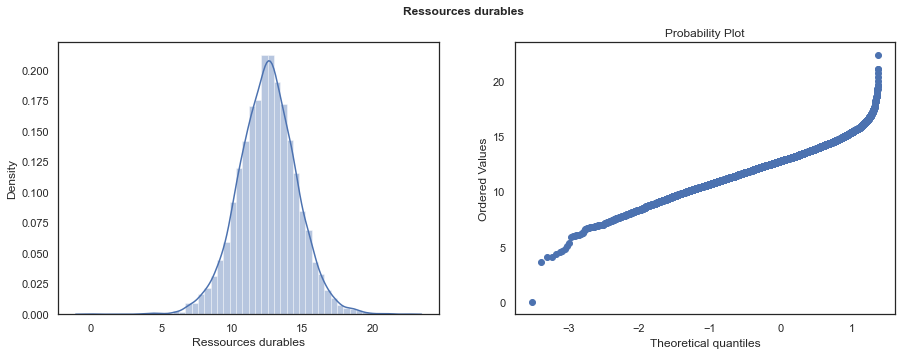

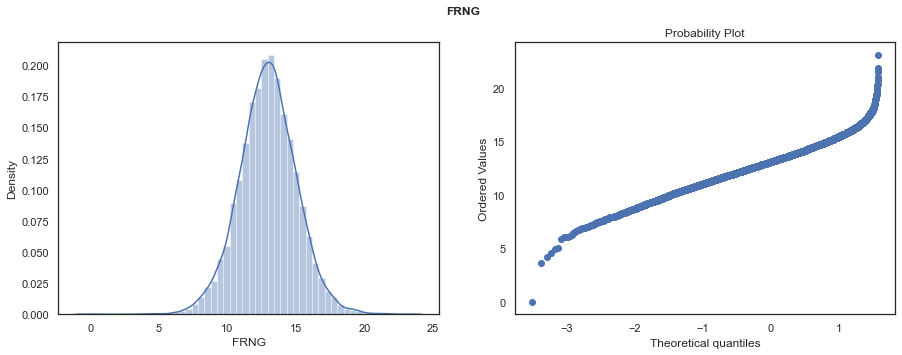

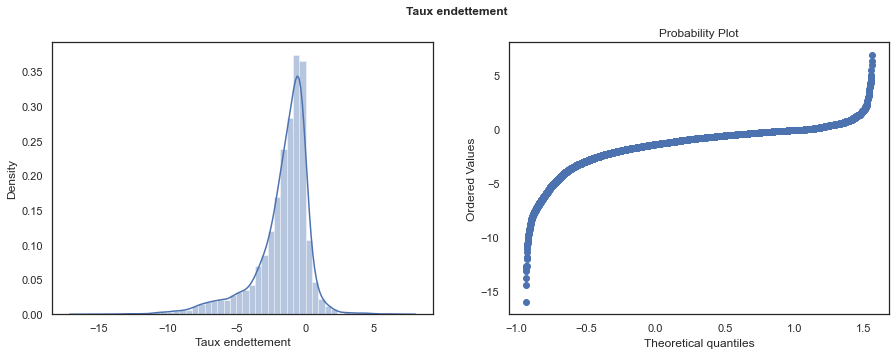

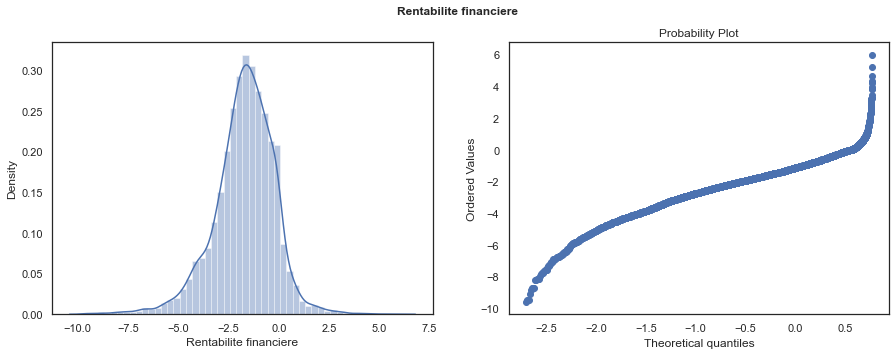

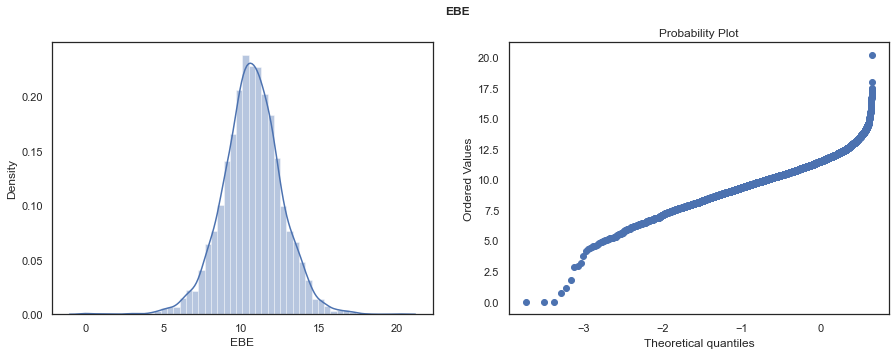

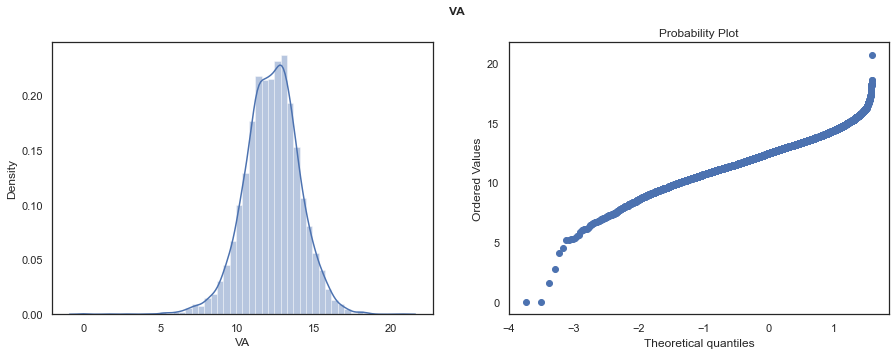

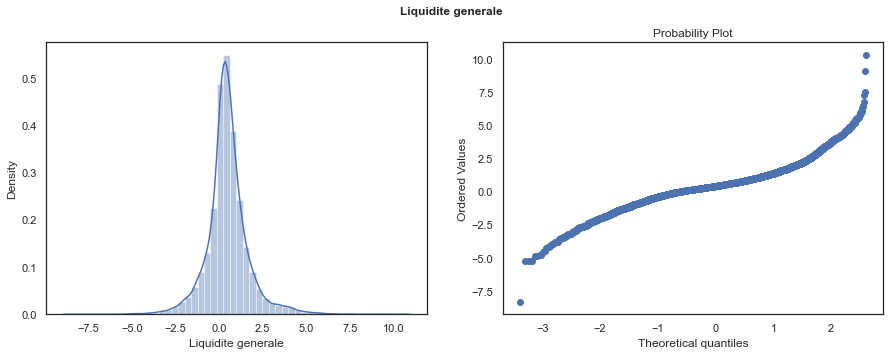

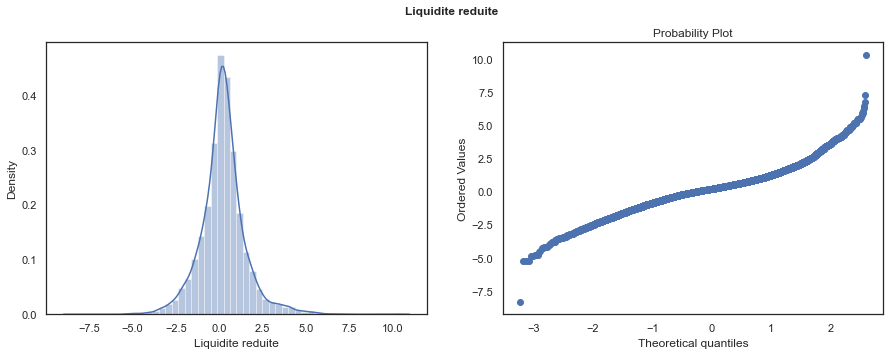

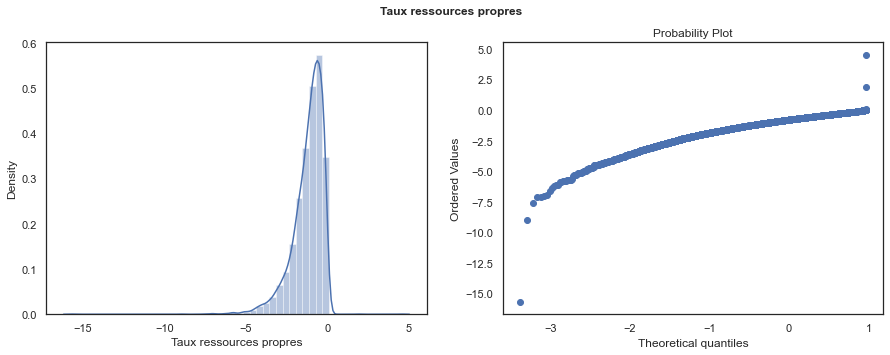

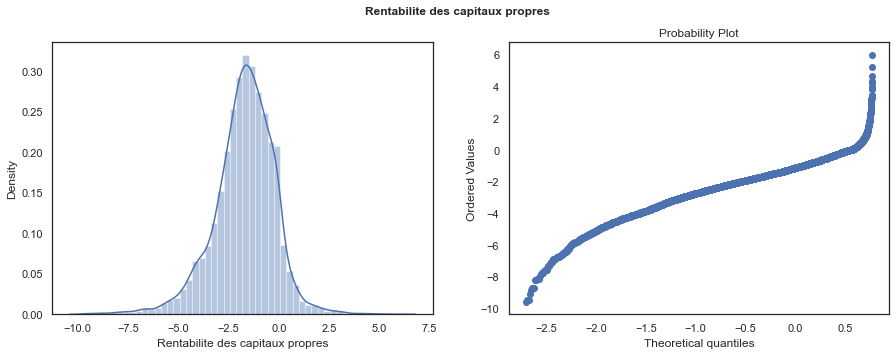

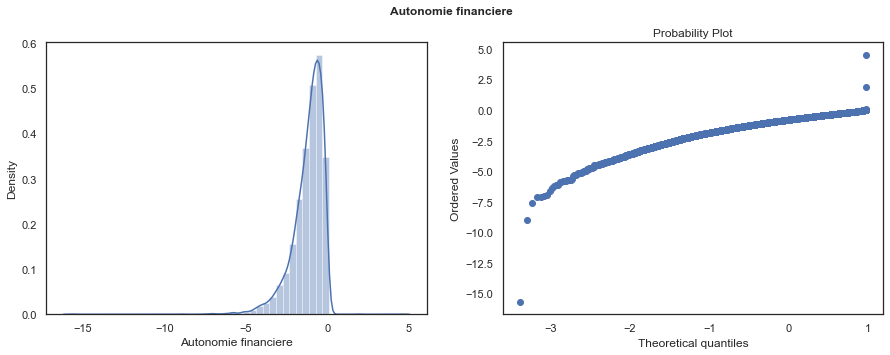

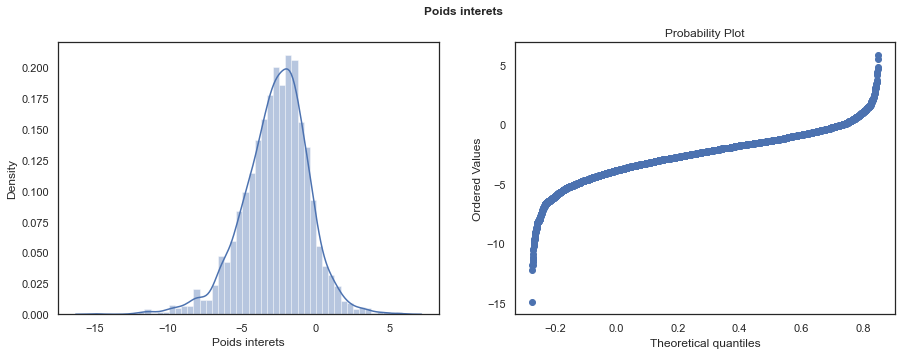

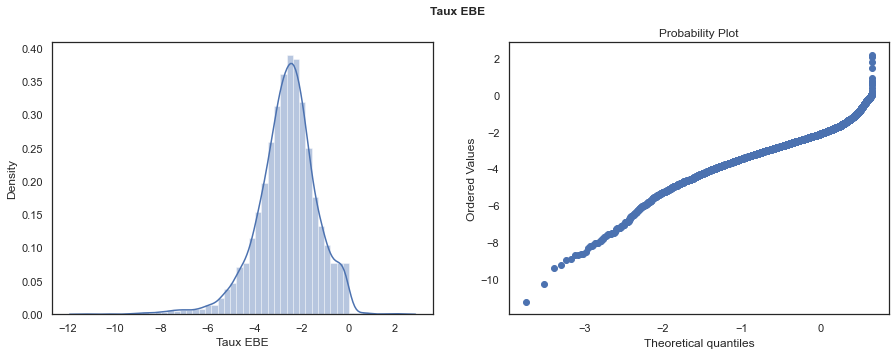

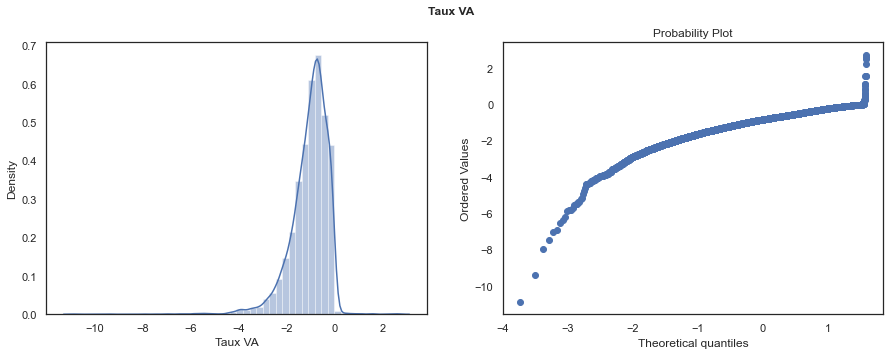

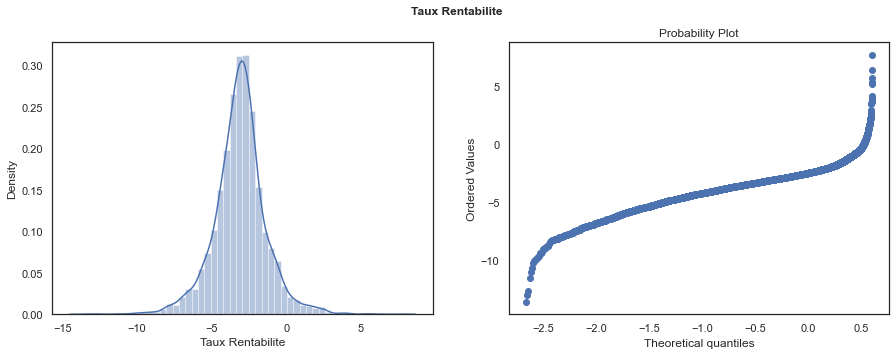

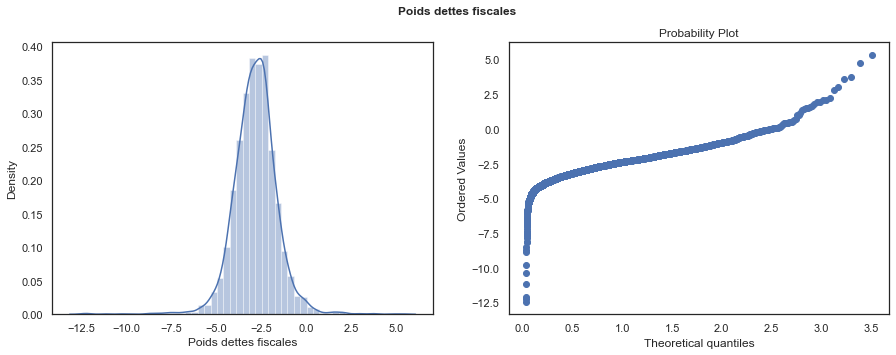

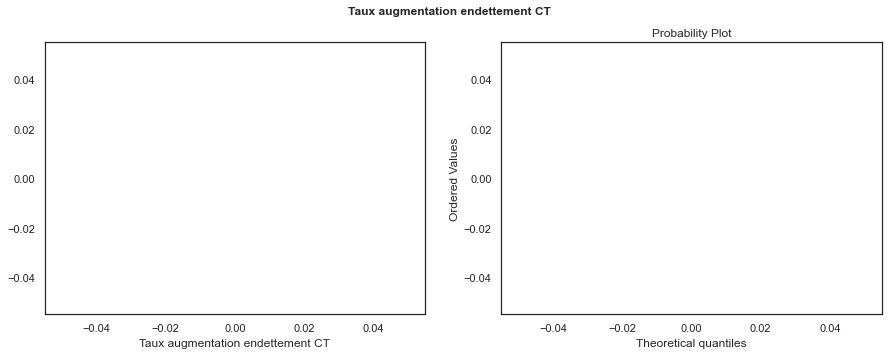

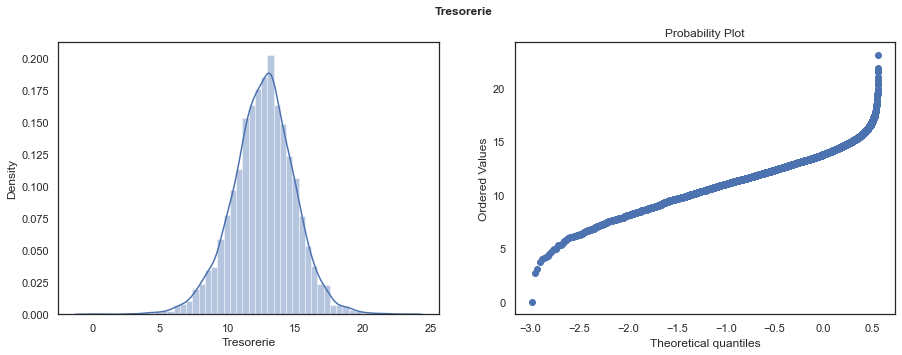

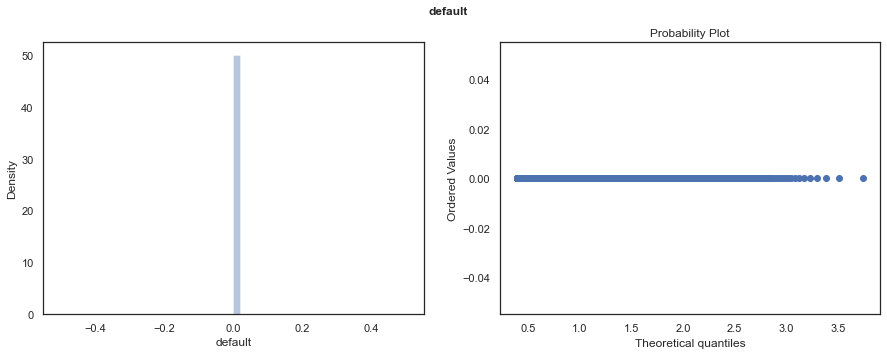

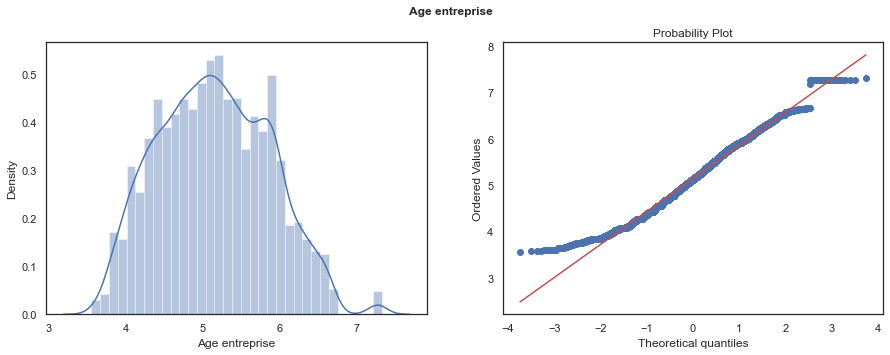

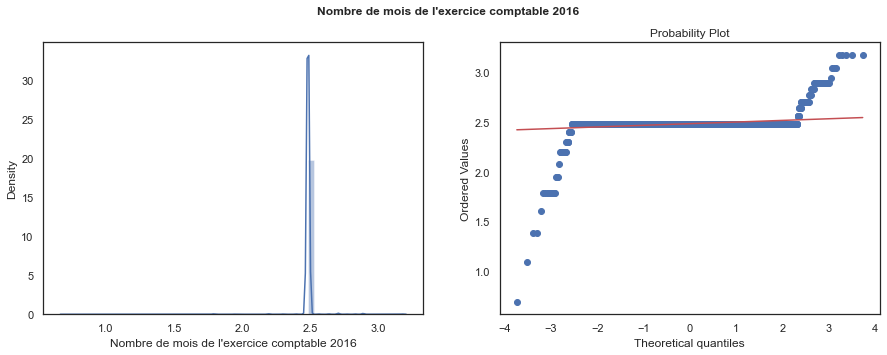

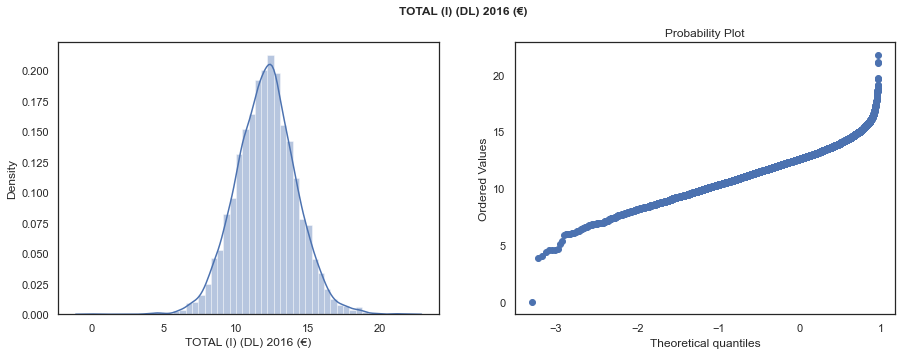

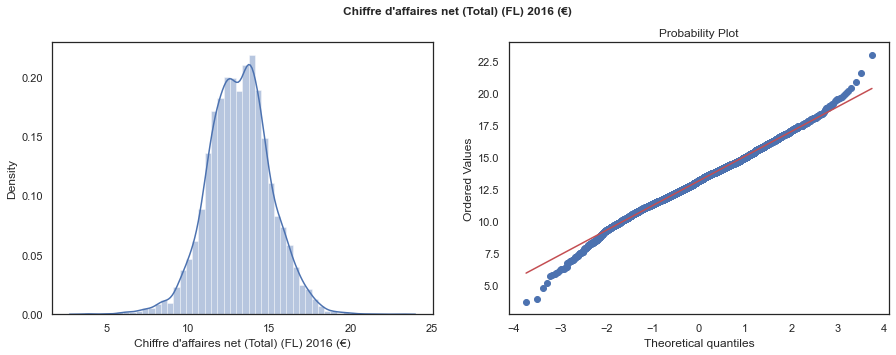

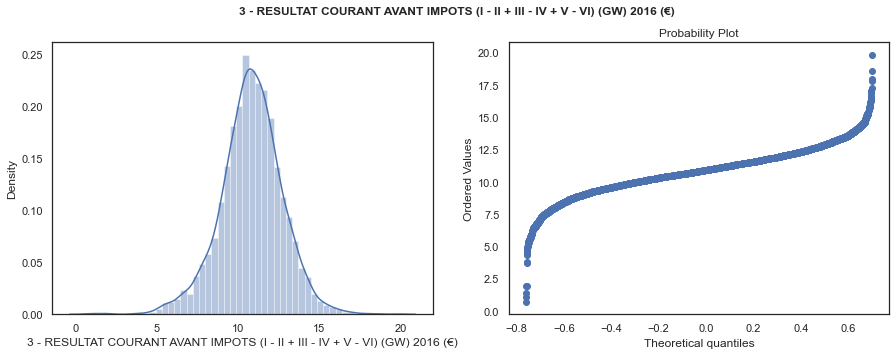

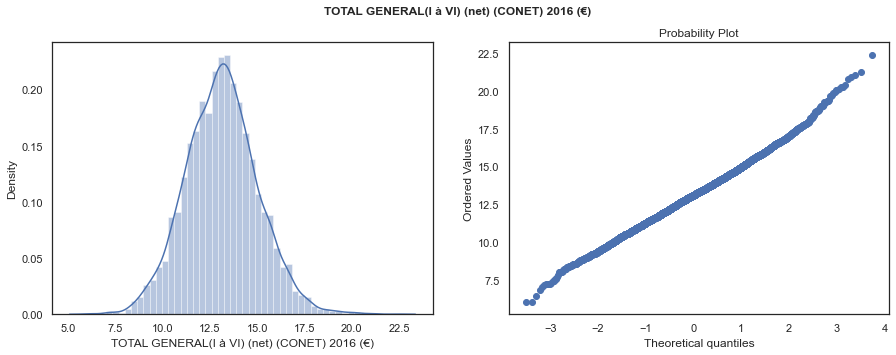

In [283]:
# Histogramme des variables continues
from scipy import stats

for col in eda_log.select_dtypes('number'):
    fig, ((axe1,axe2)) = plt.subplots(nrows=1,ncols=2, figsize = (15,5))
    fig.suptitle(f'{col}', fontsize=12,fontweight="bold")
    
    #sns.histplot(data=eda2, x=col, ax=axe1)
    sns.distplot(eda_log[col], ax=axe1)
    #axe1.set_title('Distribution',fontstyle='italic',fontsize= font_size_title)
    #axe1.set_xlabel('Montant du tips en $', fontsize= font_size_axis)
    #axe1.set_ylabel('Nombre de tips', fontsize= font_size_axis)
    
    stats.probplot(eda_log[col], plot=sns.mpl.pyplot)

- Problème de la transformation en logs => ne marche pas sur les 0 ou les valeurs négatives
- Si on veut conserver la transformation en logs : ajouter une constante à toutes les données (mais si j'ai des ratios ?). 
    - Soit la constante 1, 
    - soit la constante corresondant à x/2, x étant la plus petite valeur non nulle observée dans le dataset)
    - I prefer to apply log(X - (min(X) - 1)) to eliminate log0 and negativity problems
    - Sur les ratios : if your data were ratio data, the only transformations you could make would be multiplicative transformations, because adding a constant destroys the rational zero. However, because your data are interval, any linear transformation is fine--according to Keith Widaman in a lecture he gave at UC Davis. If your data were ratio (i.e., did have an absolute zero), you could use the square root transformation rather than a log+1 transformation.
- Sinon on a d'autres options :
    - lae passage en racine carrée (mais marche surtout pour des distributions avec slight right skew
    - la box-cox transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)

Use Box-Cox transformation for data having zero values.This works fine with zeros (although not with negative values). However, often the square root is not a strong enough transformation to deal with the high levels of skewness (we generally do sqrt transformation for right skewed distribution) seen in real data. If you are using are than can use function boxcox.fit() in package named geoR.

In [288]:
# total de NaN sur le dataset
eda_log.isna().sum().sum()/(eda_log.shape[0]*eda_log.shape[1])*100

24.29612993522768

In [289]:
# taux de NaN par colonne
(eda_log.isna().sum()/eda_log.shape[0]).sort_values(ascending=False)

Taux augmentation endettement CT                                               1.00000
default                                                                        0.65373
BFRE                                                                           0.63762
Poids interets                                                                 0.58942
Poids dettes fiscales                                                          0.51437
3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)   0.46549
Capacite de remboursement                                                      0.38923
Rotation_stocks                                                                0.38306
Tresorerie                                                                     0.28934
Taux Rentabilite                                                               0.27846
CAF                                                                            0.27256
Taux EBE                                   

## Deuxième essai : un passage de tout le dataset en racine carrée

In [295]:
eda_root = np.sqrt(eda2_num)

In [296]:
# taux de NaN par colonne
(eda_root.isna().sum()/eda_root.shape[0]).sort_values(ascending=False)

BFRE                                                                           0.63520
Tresorerie                                                                     0.28800
Taux Rentabilite                                                               0.27470
EBE                                                                            0.25564
Taux EBE                                                                       0.25564
CAF                                                                            0.25403
3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)   0.24181
Capacite de remboursement                                                      0.22476
Rentabilite des capitaux propres                                               0.21979
Rentabilite financiere                                                         0.21979
BFR                                                                            0.20677
Poids interets                             

## Troisième essai - ratios en rootsquare et montants en log après ajout de constante (et peut-être suppression des valeurs négatives trop extrêmes)

In [298]:
eda2_num.columns

Index(['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 'Endettement total', 'CAF', 'Capacite de remboursement', 'Ressources durables', 'FRNG', 'Taux endettement', 'Rentabilite financiere', 'EBE', 'VA', 'Liquidite generale', 'Liquidite reduite', 'Taux ressources propres', 'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Taux augmentation endettement CT', 'Tresorerie', 'default', 'Age entreprise', 'Nombre de mois de l'exercice comptable 2016', 'TOTAL (I) (DL) 2016 (€)', 'Chiffre d'affaires net (Total) (FL) 2016 (€)', '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)'], dtype='object')

In [299]:
# fonction de récap infos sur df
def df_info(df):
        len_df = len(df)
        all_columns = len(df.columns)
        all_nan = df.isna().sum().sum()
        list_of_numerics = df.select_dtypes(include = ['float','int']).columns
        print(f"""
        Longueur du dataset : {len_df} enregistrements
        Nombre de colonnes : {all_columns}
        """)
        echantillonColonnes = []
        for i in df.columns:
            listcolumn = str(list(df[i].head(5)))
            echantillonColonnes.append(listcolumn)
        obs = pd.DataFrame({'type': list(df.dtypes),
        'Echantillon': echantillonColonnes,
        "% de valeurs nulles":
        round(df.isna().sum() / len_df * 100, 2),
                            "% de valeurs négatives":
        'Nbr L dupliquées' : (df.duplicated()).sum(),
        'Nbr V unique' : df.nunique(),
        'Nbr Outliers' : df.apply(lambda x: sum(
                                 (x<(x.quantile(0.25) - 1.5 * (x.quantile(0.75)-x.quantile(0.25)))) |
                                 (x>(x.quantile(0.75) + 1.5 * (x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))
        })
        return obs

In [301]:
eda2_num.columns

Index(['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 'Endettement total', 'CAF', 'Capacite de remboursement', 'Ressources durables', 'FRNG', 'Taux endettement', 'Rentabilite financiere', 'EBE', 'VA', 'Liquidite generale', 'Liquidite reduite', 'Taux ressources propres', 'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Taux augmentation endettement CT', 'Tresorerie', 'default', 'Age entreprise', 'Nombre de mois de l'exercice comptable 2016', 'TOTAL (I) (DL) 2016 (€)', 'Chiffre d'affaires net (Total) (FL) 2016 (€)', '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)'], dtype='object')

In [302]:
eda2_num.describe()

Credit client  Credit Fournisseurs  Rotation_stocks             BFR             BFRE  Endettement total             CAF  Capacite de remboursement  Ressources durables              FRNG  Taux endettement  Rentabilite financiere             EBE              VA  Liquidite generale  Liquidite reduite  Taux ressources propres  Rentabilite des capitaux propres  Autonomie financiere  Poids interets    Taux EBE    Taux VA  Taux Rentabilite  Poids dettes fiscales  Taux augmentation endettement CT        Tresorerie    default  Age entreprise  Nombre de mois de l'exercice comptable 2016  TOTAL (I) (DL) 2016 (€)  Chiffre d'affaires net (Total) (FL) 2016 (€)  3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)  TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)
count     7448.00000           7440.00000       7448.00000      7448.00000       7448.00000         7448.00000      7448.00000                 7310.00000           7448.00000        7448.00000        7447.00000              7445.00000      7448.00000      7448.00000          7421.00000         7421.00000               7447.00000                        7445.00000            7447.00000      7430.00000  7448.00000 7448.00000        7448.00000             7448.00000                        7447.00000        7448.00000 7448.00000      7448.00000                                   7448.00000               7448.00000                                    7448.00000                                         7448.00000                                                               7448.00000
mean       149.06680            125.67762         64.48157   1217653.48120    -184591.48443      1430184.18327    183459.27564                    2.04213        3648337.35191     6714887.71106           0.74987                 0.13080    235222.09023   1081855.18287            10.62619            8.54868                  0.17660                           0.13708               0.17783        -0.06720    -0.50258    0.00780           0.00476                0.12127                           0.00000     5497234.22986    0.34627       224.19186                                     12.02390            2123285.00792                                 5261005.59922                                       100860.74852                                                            5265292.18434
std       4192.35762           1220.41893        865.78630   9005223.35255    6440211.26202     31883314.94032   6015694.47746                  275.88182       70111200.50698   140387748.51218          15.13482                12.73119   7051974.84356  12219742.65482           370.34351          353.99647                  2.75148                          12.72784               2.75093        10.09968    16.96251   13.79397          31.32679                2.89680                           0.00000   139308870.90073    0.47581       182.05895                                      0.63510           41700019.32573                               117979510.87766                                      5416488.53358                                                           74385876.82302
min         -0.39193          -5923.69306      -4033.20408 -77080925.00000 -332866000.00000         -669.00000 -45609000.00000               -15558.33333      -16294572.00000   -13596679.00000         -80.46255              -903.55102 -23028957.00000 -14578218.00000           -13.59083           -6.06870               -189.12630                        -903.55102            -189.12630      -373.49029 -1103.89953 -944.98075        -903.12199               -0.00961                           0.00000   -44607378.00000    0.00000        35.00000                                      2.00000          -45936194.00000                                      41.00000                                    -79799577.00000                                                                  0.00000
25%          2.85627             25.77166          0.00000      8614.25000   

In [ ]:
#compter les valeurs négatives et les afficher dans un heatmap
# afficher le % de valeurs négatives et les afficher dans le résumé
# afficher, pour chaque colonne, seulement la distribution des valeurs négatives ou nulles




<Figure size 432x288 with 0 Axes>

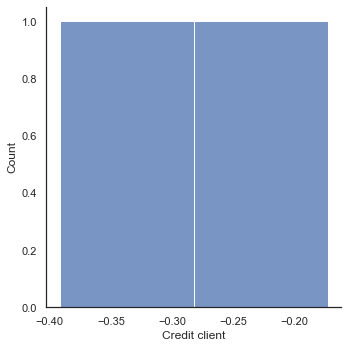

<Figure size 432x288 with 0 Axes>

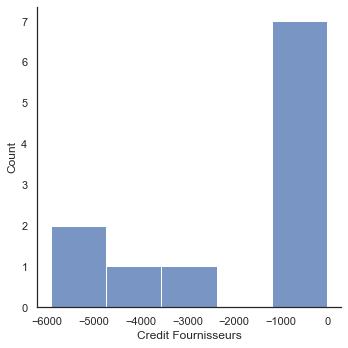

<Figure size 432x288 with 0 Axes>

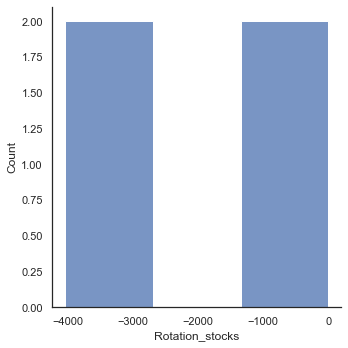

<Figure size 432x288 with 0 Axes>

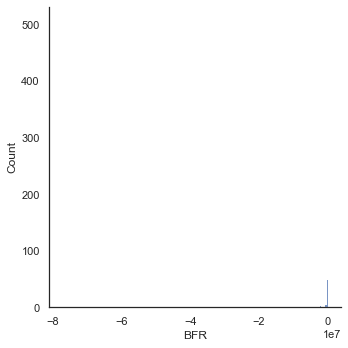

<Figure size 432x288 with 0 Axes>

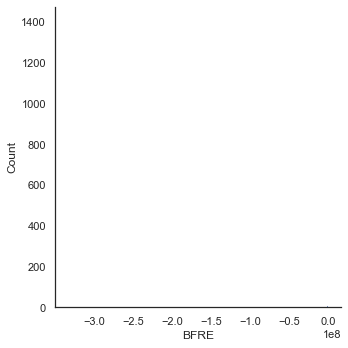

<Figure size 432x288 with 0 Axes>

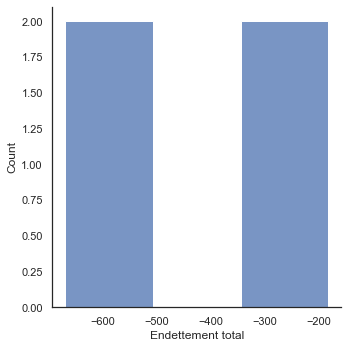

<Figure size 432x288 with 0 Axes>

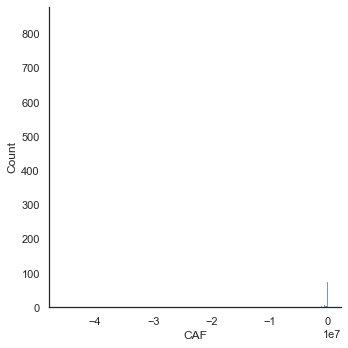

<Figure size 432x288 with 0 Axes>

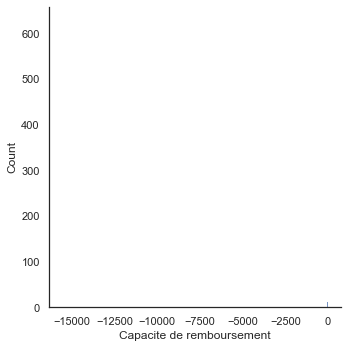

<Figure size 432x288 with 0 Axes>

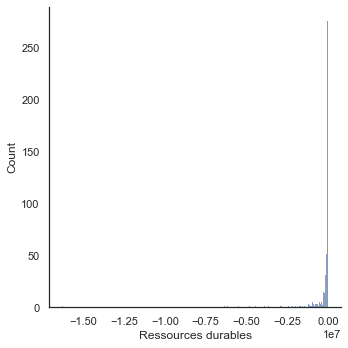

<Figure size 432x288 with 0 Axes>

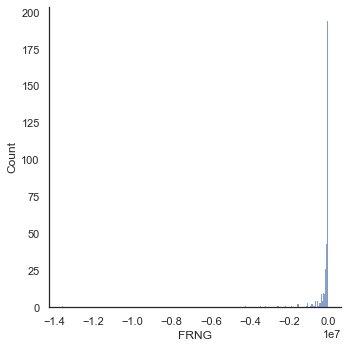

<Figure size 432x288 with 0 Axes>

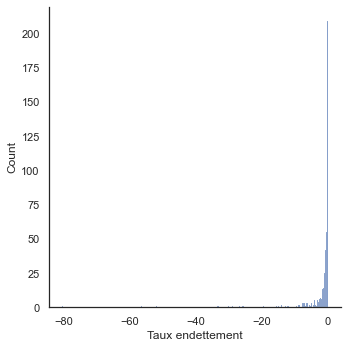

<Figure size 432x288 with 0 Axes>

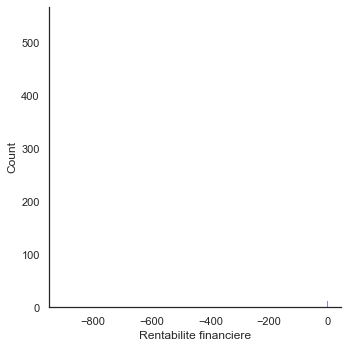

<Figure size 432x288 with 0 Axes>

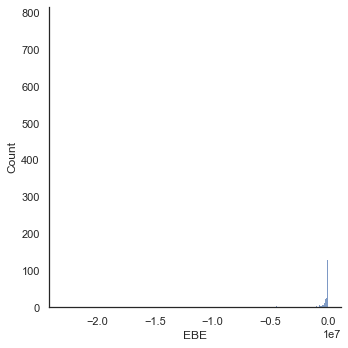

<Figure size 432x288 with 0 Axes>

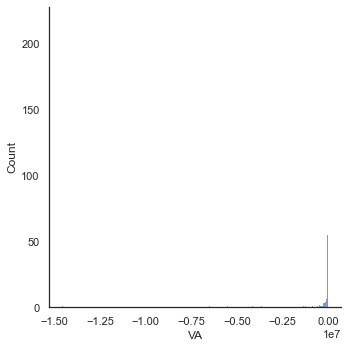

<Figure size 432x288 with 0 Axes>

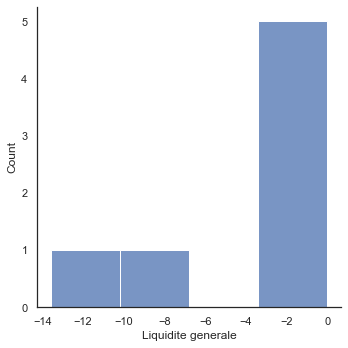

<Figure size 432x288 with 0 Axes>

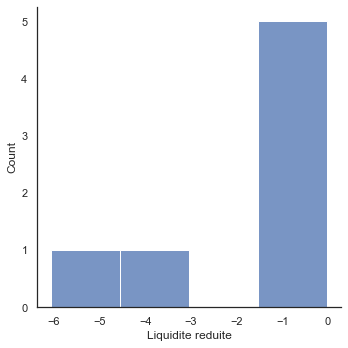

<Figure size 432x288 with 0 Axes>

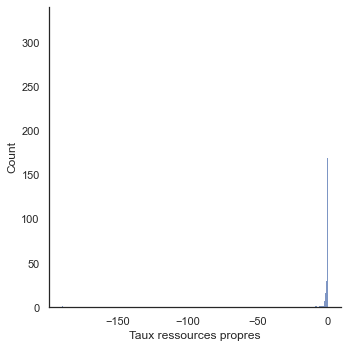

<Figure size 432x288 with 0 Axes>

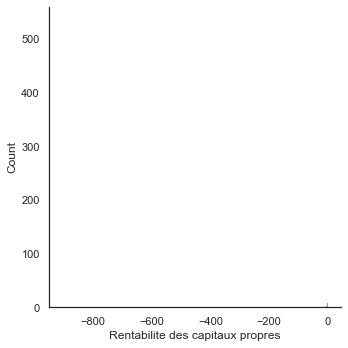

<Figure size 432x288 with 0 Axes>

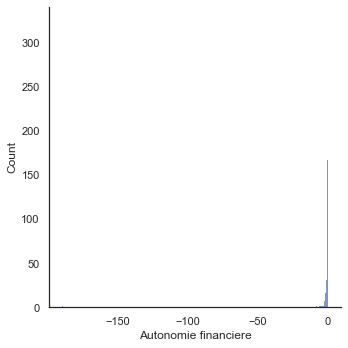

<Figure size 432x288 with 0 Axes>

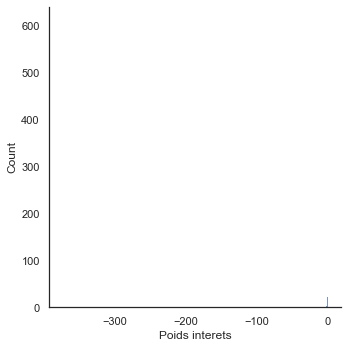

<Figure size 432x288 with 0 Axes>

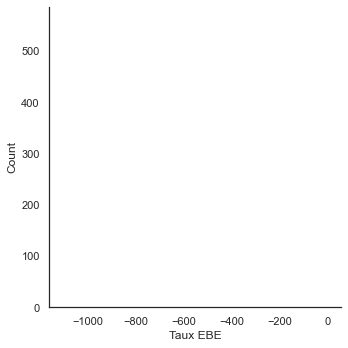

<Figure size 432x288 with 0 Axes>

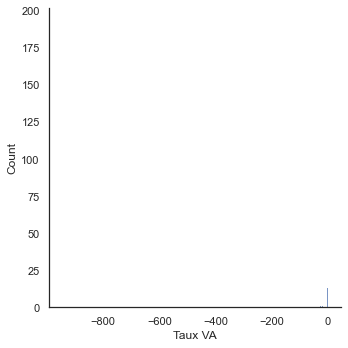

<Figure size 432x288 with 0 Axes>

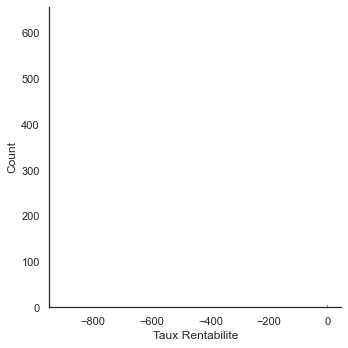

<Figure size 432x288 with 0 Axes>

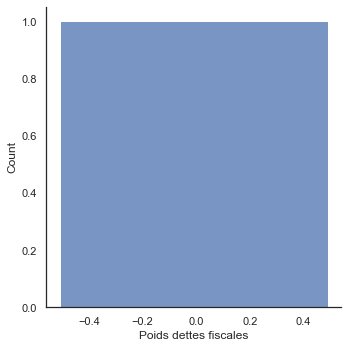

<Figure size 432x288 with 0 Axes>

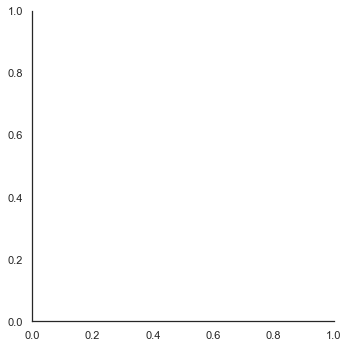

<Figure size 432x288 with 0 Axes>

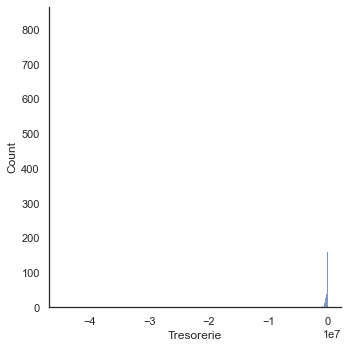

<Figure size 432x288 with 0 Axes>

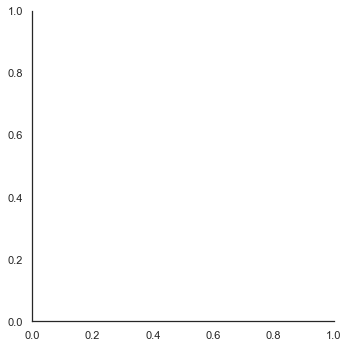

<Figure size 432x288 with 0 Axes>

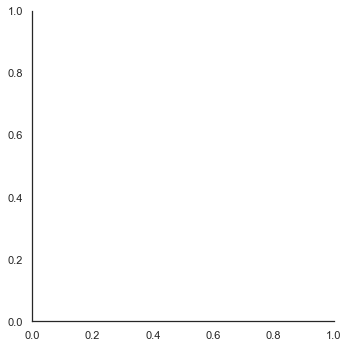

<Figure size 432x288 with 0 Axes>

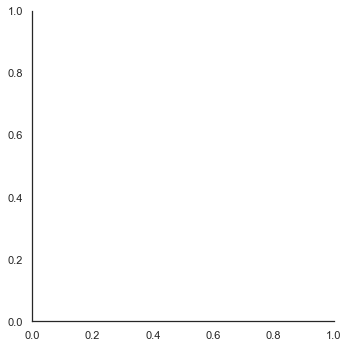

<Figure size 432x288 with 0 Axes>

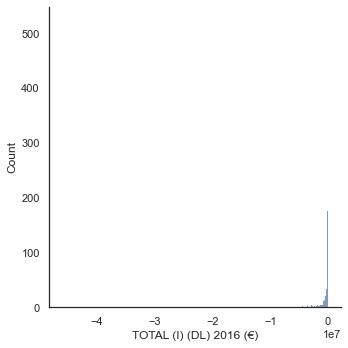

<Figure size 432x288 with 0 Axes>

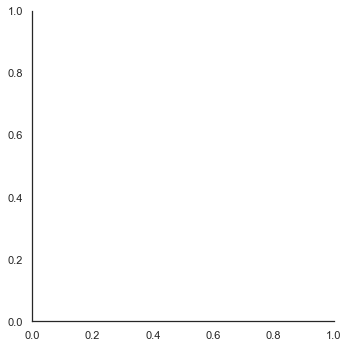

<Figure size 432x288 with 0 Axes>

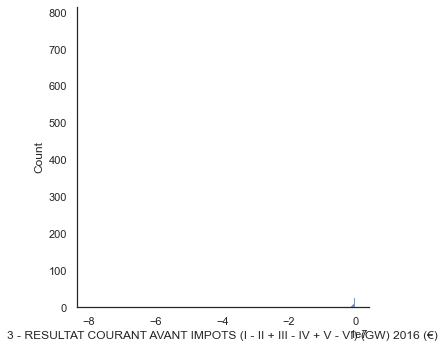

<Figure size 432x288 with 0 Axes>

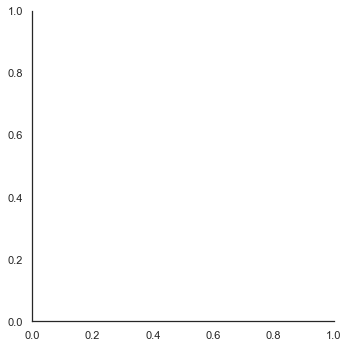

In [307]:
for col in eda2_num.columns:
    plt.figure()
    sns.displot(x=eda2_num[col][eda2_num[col] < 0])
    plt.show()

In [ ]:
montants = ['Credit client', 'Credit Fournisseurs', 'Rotation_stocks', 'BFR', 'BFRE', 
            'Endettement total', 'CAF', 'Ressources durables', 'FRNG', 'EBE', 'VA',
           'Tresorerie', 'default', 'Age entreprise', "Nombre de mois de l'exercice comptable 2016",
            'TOTAL (I) (DL) 2016 (€)', "Chiffre d'affaires net (Total) (FL) 2016 (€)", 
            '3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2016 (€)', 
            'TOTAL GENERAL(I à VI) (net) (CONET) 2016 (€)']
ratios = ['Taux endettement', 'Rentabilite financiere','Taux ressources propres', 
          'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 
          'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 
          'Taux augmentation endettement CT']
ne_pas_transformer = ['default', 'Age entreprise', "Nombre de mois de l'exercice comptable 2016"]

In [300]:
df_info(eda2_num)


        Longueur du dataset : 7448 enregistrements
        Nombre de colonnes : 33
        


type                                        Echantillon  % de valeurs nulles  Nbr L dupliquées  Nbr V unique  Nbr Outliers
Credit client                                       float64  [119.28387877364977, 0.4769843722342654, 163.4...              0.00000                24          6044           513
Credit Fournisseurs                                 float64  [63.569930386133436, 4.12811238024758, 96.6624...              0.11000                24          7171           665
Rotation_stocks                                     float64  [8.191101273826574, 5.887922421274676, 4.08910...              0.00000                24          4561           883
BFR                                                   int64    [2867585, 18986082, 5877127, 14061980, 4478866]              0.00000                24          7348          1141
BFRE                                                  int64   [18956335, -616923, -2463169, 8962229, -1712191]              0.00000                24          7288          1763
Endettement total                                     int64            [49351120, 1234281, 600000, 3538595, 0]              0.00000                24          5874          1084
CAF                                                   int64       [16515757, 1315119, 1492771, 552350, 899961]              0.00000                24          7049          1453
Capacite de remboursement                           float64  [2.988123402396875, 0.9385317982631229, 0.4019...              1.85000                24          6034          1618
Ressources durables                                   int64    [160209280, 9736935, 6639270, 9201470, 3649621]              0.00000                24          7360          1018
FRNG                                                  int64   [320580295, 9794289, 7793630, 12603487, 5924407]              0.00000                24          7365          1053
Taux endettement                                    float64  [0.3080415816112525, 0.12676278520910328, 0.09...              0.01000                24          6086           497
Rentabilite financiere                              float64  [-0.6535413334599146, 0.1509149406796702, 0.18...              0.04000                24          7356          1092
EBE                                                   int64     [17339578, 1935021, 2561190, 1101071, 1435027]              0.00000                24          7256          1369
VA                                                    int64   [121978801, 2298220, 18220169, 7152562, 1786633]              0.00000                24          7344           905
Liquidite generale                                  float64  [1.6690012231389981, 5.192547607134576, 1.3029...              0.36000                24          7358           869
Liquidite reduite                                   float64  [1.5725644035760467, 4.528412607369932, 1.2866...              0.36000                24          7356           863
Taux ressources propres                             float64  [0.3871565760062349, 0.701846452527611, 0.1748...              0.01000                24          7373           415
Rentabilite des capitaux propres                    float64  [-0.6535413334599146, 0.1509149406796702, 0.17...              0.04000                24          7356          1091
Autonomie financiere                                float64  [0.3871565760062349, 0.701846452527611, 0.1803...              0.01000                24          7373           414
Poids interets                                      float64  [-8.131852569824474e-05, 0.0, 0.00063078608354...              0.24000                24          4472          2103
Taux EBE                                            float64  [0.09995002953324333, 0.020055369839548937, 0....              0.00000                24          7385          1233
Taux VA                                             float64  [0.7031188857294919, 0.023819716722789135, 0.6...              0.00000        

In [ ]:
# Histogramme des variables continues
for col in eda2.select_dtypes('number'):
    plt.figure()
    sns.histplot(eda2[col], stat="density")
    #sns.distplot(df[col])
    #sns.
    # rajouter qq plot
    # rajouter lien avec la target ?

In [ ]:
fig, ((axe1,axe2),(axe3,axe4)) = plt.subplots(nrows=2,ncols=2, figsize = (15,18))

font_size_title = 16
font_size_axis = 12

fig.suptitle('Analyse du jeu de donnée tips de Seaborn', fontsize=18,fontweight="extra bold")

sns.histplot(data=data, x='tip', ax=axe1)
axe1.set_title('Distribution du montant des tips',fontstyle='italic',fontsize= font_size_title)
axe1.set_xlabel('Montant du tips en $', fontsize= font_size_axis)
axe1.set_ylabel('Nombre de tips', fontsize= font_size_axis)


axe2.scatter(x='total_bill', y='tip', data=data,c='red')
axe2.set_title("Correlation entre \n le montant du tips et le montant de l'addition",fontstyle='italic',fontsize= font_size_title)
axe2.set_xlabel("Montant de l'addition en $", fontsize= font_size_axis)
axe2.set_ylabel("Montant du tips en $", fontsize= font_size_axis)


axe3.scatter(x='day',y='tip',data=data, color='green')
axe3.set_title('Repartition du montant du pourboire \npar rapport au jour',fontstyle='italic',fontsize= font_size_title)
axe3.set_xlabel("Jours", fontsize= font_size_axis)
axe3.set_ylabel("Montant du tips en $", fontsize= font_size_axis)
axe3.set_yticks([2,4,6,8,10])
axe3.set_yticklabels(['2 $','4 $','6 $','8 $','10 $'])



sns.regplot(x='size', y='tip', data=data, ax=axe4, color='black', ci=95)
axe4.set_title('Montant du tips en fonction \ndu nombre de personne à la table',fontstyle='italic',fontsize= font_size_title)
axe4.set_xlabel("Nombre de personne à une table", fontsize= font_size_axis)
axe4.set_ylabel("Montant du tips en $", fontsize= font_size_axis)

for axe in [axe1,axe2,axe3,axe4]:
    remove_spines(axe)

plt.show()